### Прогноз модели ARIMA/VAR


Документация по статистическим моделям:
https://www.statsmodels.org/stable/index.html

In [36]:
import numpy as np
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("pastel")

import warnings
warnings.filterwarnings("ignore")

## Data analysis

In [1]:
data = pd.read_csv("deposit.csv", sep=";")
data["Date"] = pd.to_datetime(data["Date"], format="%d.%m.%Y")
data.set_index("Date", inplace=True)
data["Deposit_rub"] = (
    data["Deposit_rub"].apply(lambda x: x.replace(",", ".")).astype(float)
)
# data["Deposit_currency"] = (
#     data["Deposit_currency"].apply(lambda x: x.replace(",", ".")).astype(float)
# )

In [2]:
data.head()

,Deposit_rub,Deposit_currency,Inflation
Date,,,
2014-01-01,14000569.0,"2956962,00","0,34"
2014-02-01,13433121.0,"3256299,00","0,59"
2014-03-01,13510318.0,"3397706,00","0,99"
2014-04-01,13206977.0,"3356873,00","0,88"
2014-05-01,13507416.0,"3340055,00","0,94"


Text(0.5, 0, 'Months')

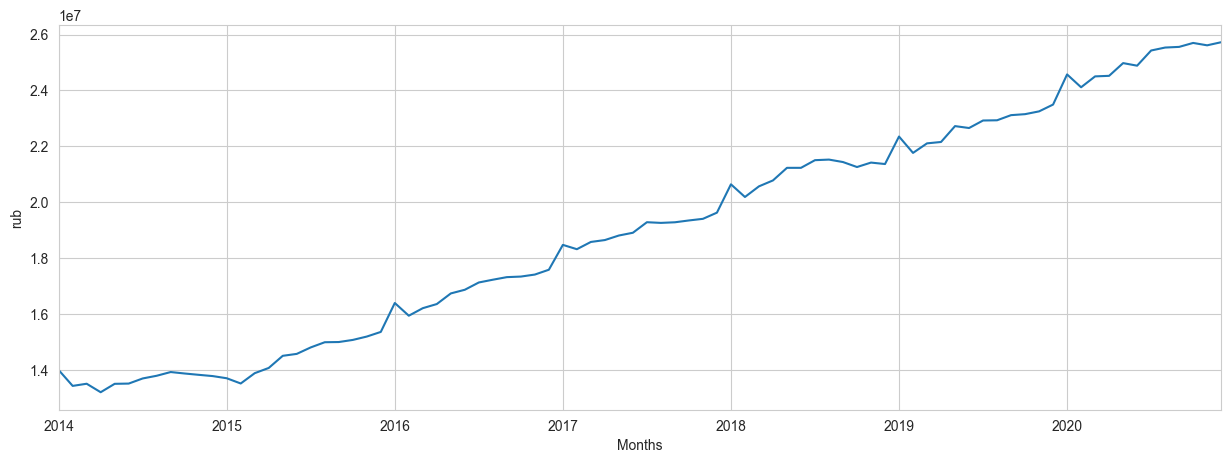

In [3]:
plt.figure(figsize=(15, 5))
data.Deposit_rub.plot()
plt.ylabel("rub")
plt.xlabel("Months")

In [4]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Deposit_rub)[1])

Dickey-Fuller test: p=0.914995


<Figure size 2000x500 with 0 Axes>

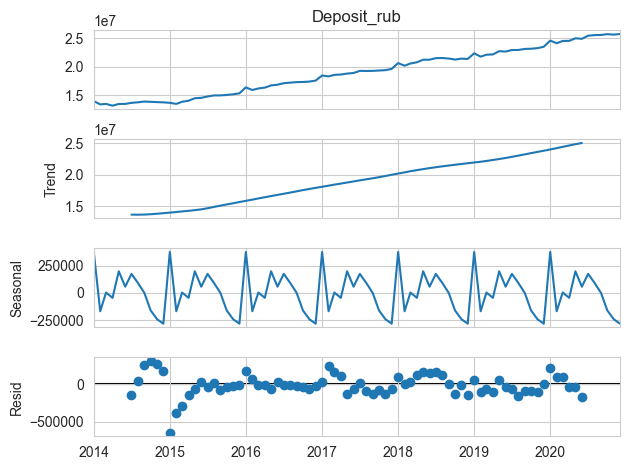

In [5]:
plt.figure(figsize=(20, 5))
sm.tsa.seasonal_decompose(data.Deposit_rub).plot()
plt.show()

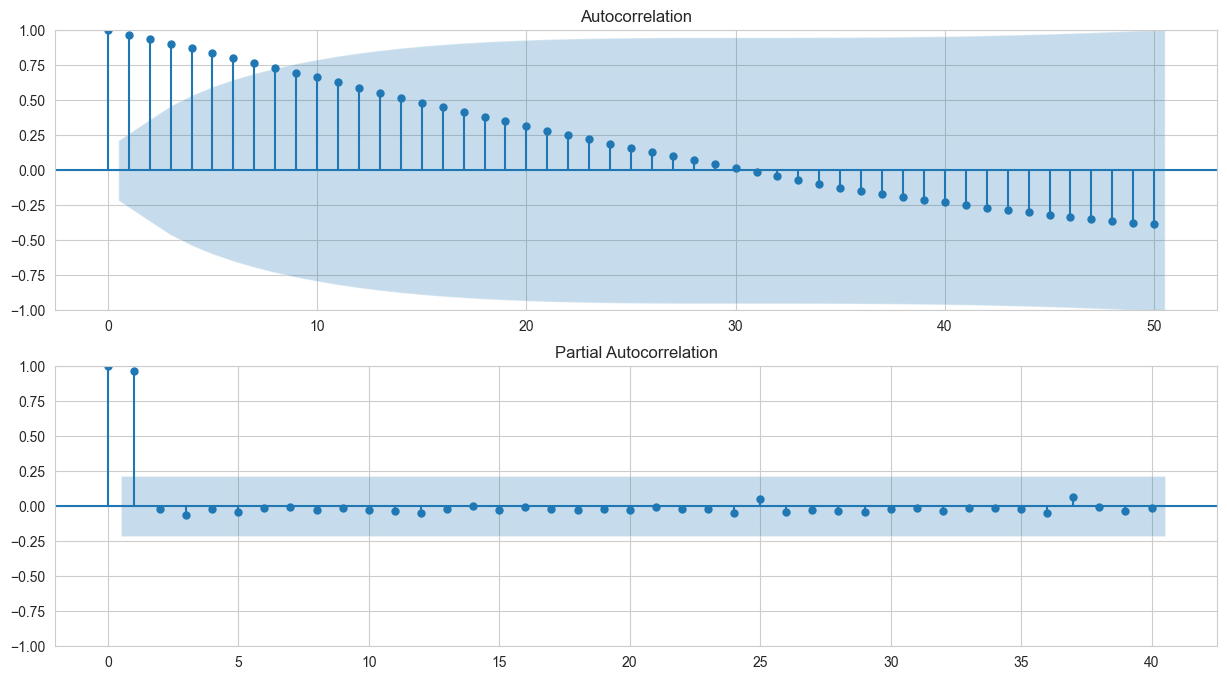

In [6]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize=(15, 8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.Deposit_rub.values.squeeze(), lags=50, ax=ax)

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.Deposit_rub.values.squeeze(), lags=40, ax=ax)
plt.show()

Best Box-Cox parameter: 0.408736
Dickey-Fuller test: p=0.368960


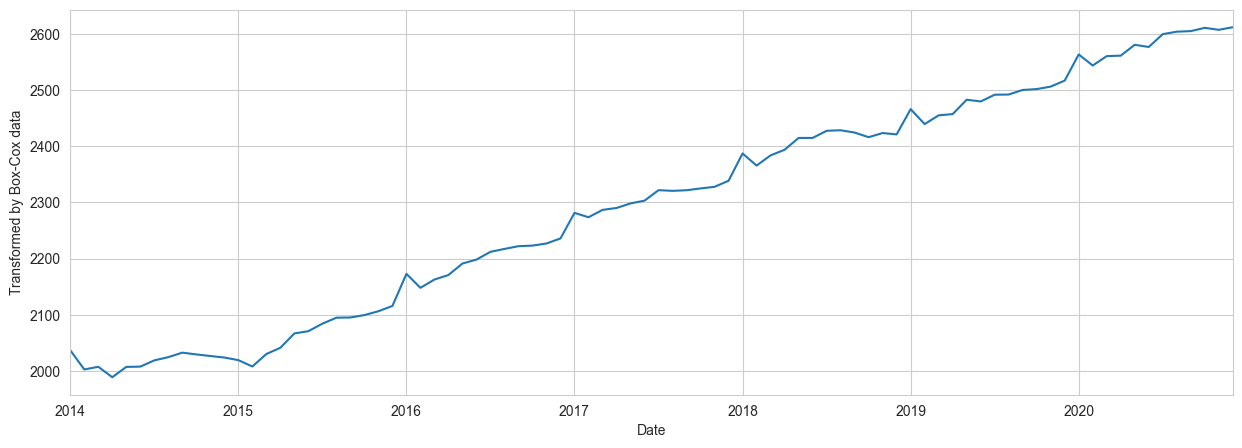

In [7]:
# Box-Cox transformation for dispersion stationarity

data["deposit_rub_box"], lmbda = stats.boxcox(data.Deposit_rub)
plt.figure(figsize=(15, 5))
data.deposit_rub_box.plot()
plt.ylabel("Transformed by Box-Cox data")
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.deposit_rub_box)[1])

In [8]:
plt.rcParams["figure.figsize"] = (15, 10)

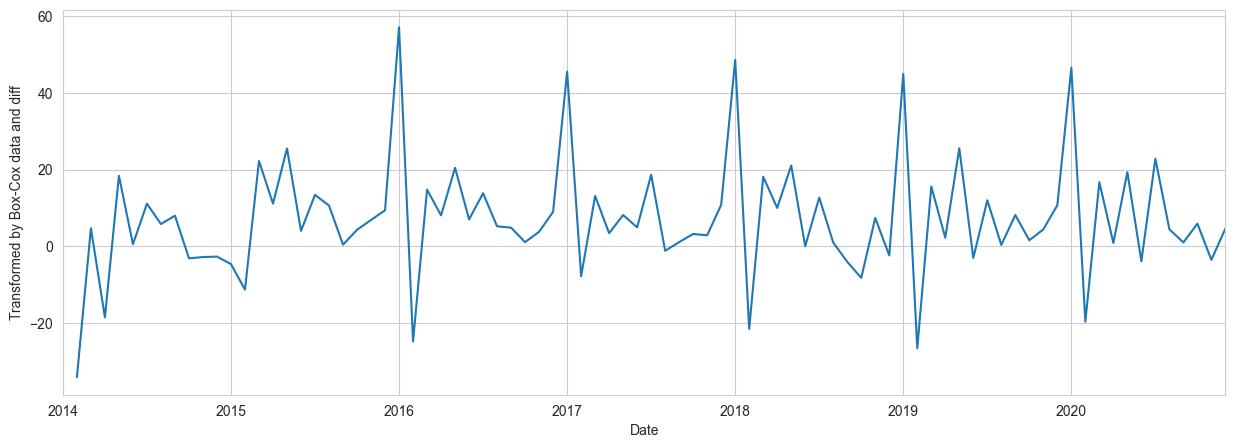

Dickey-Fuller test: p=0.004385


In [9]:
# difference for 1 months

data["deposit_rub_box_diff"] = data.deposit_rub_box - data.deposit_rub_box.shift(1)
plt.subplots(figsize=(15, 5))
data.deposit_rub_box_diff.plot()
plt.ylabel("Transformed by Box-Cox data and diff")
plt.show()
print(
    "Dickey-Fuller test: p=%f"
    % sm.tsa.stattools.adfuller(data.deposit_rub_box_diff[1:])[1]
)

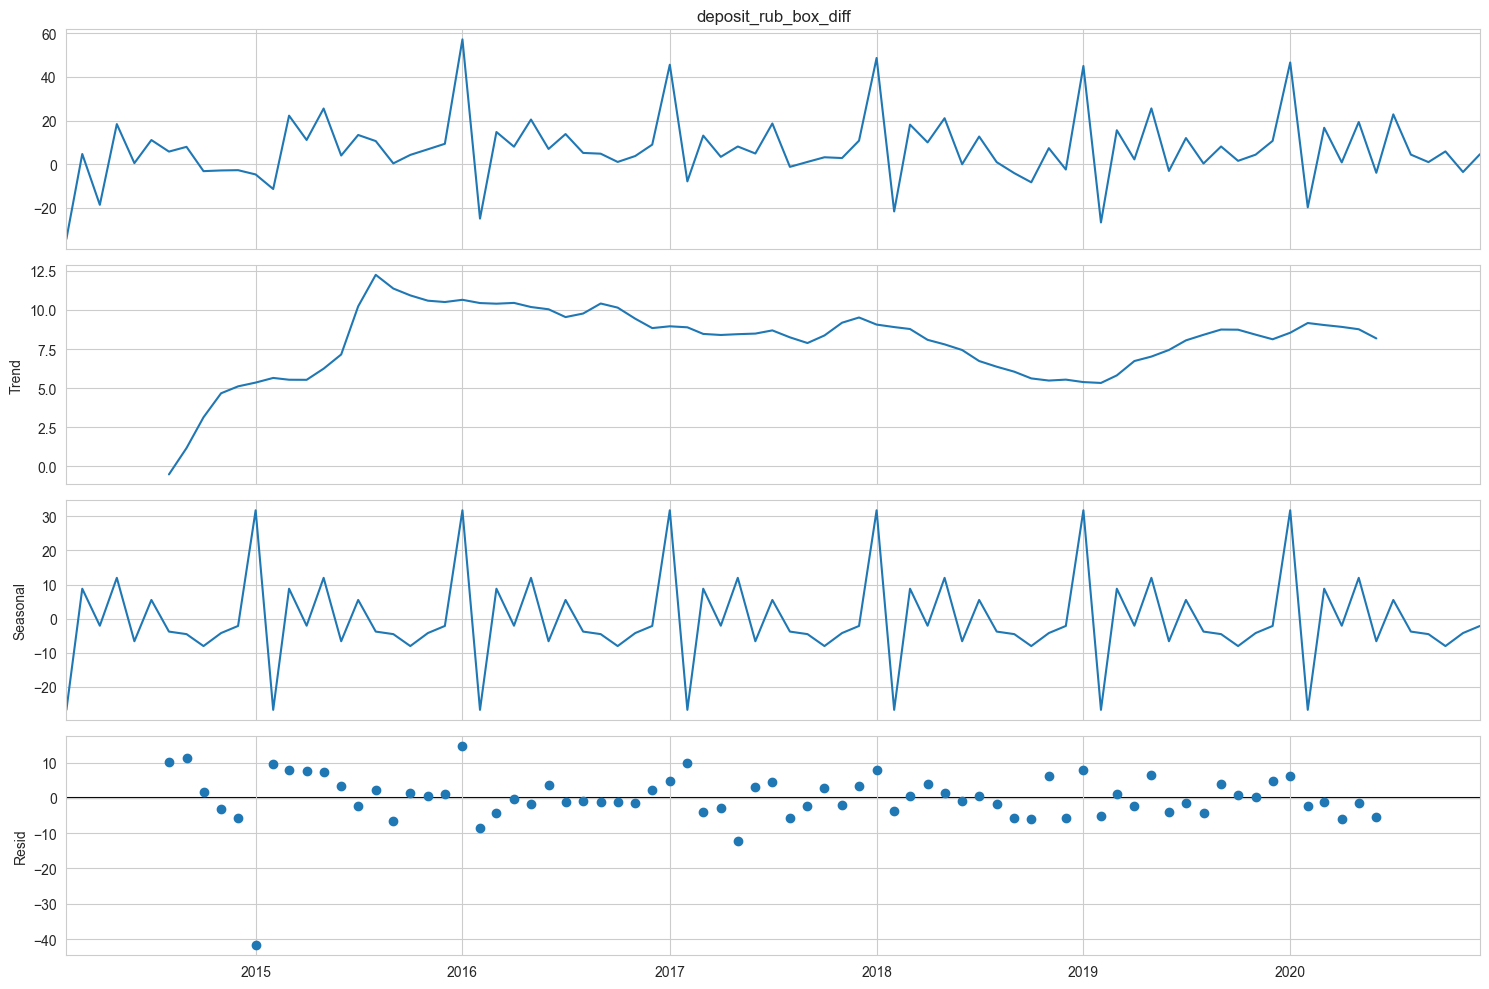

In [10]:
sm.tsa.seasonal_decompose(data.deposit_rub_box_diff[1:]).plot()
plt.show()

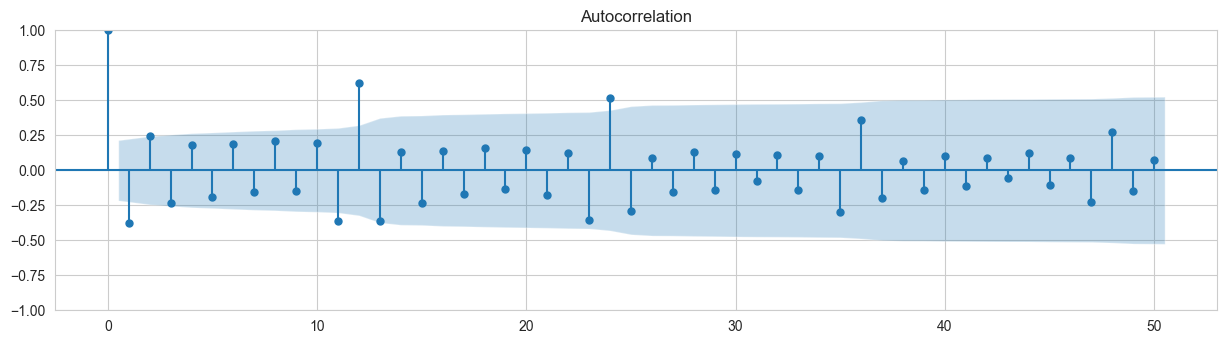

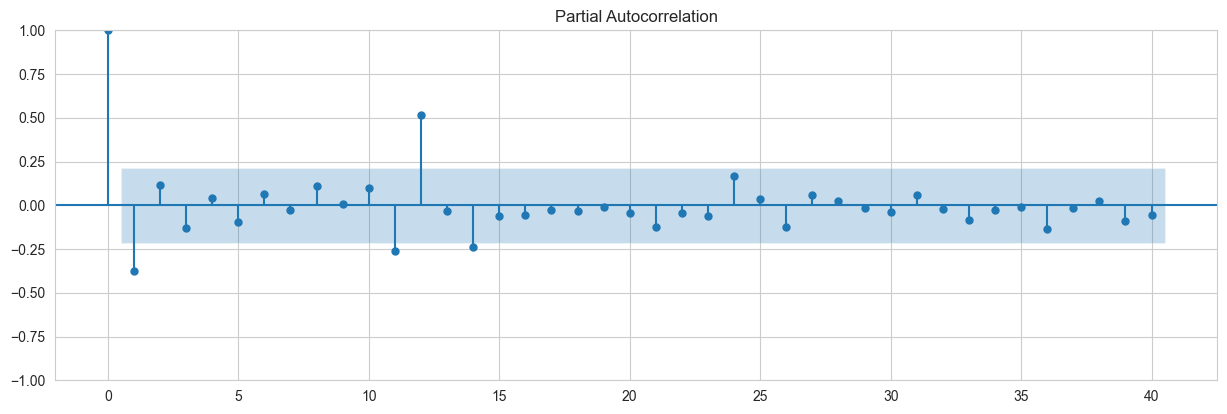

In [11]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize=(15, 8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.deposit_rub_box_diff[1:].values.squeeze(), lags=50, ax=ax)
plt.show()

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    data.deposit_rub_box_diff[1:].values.squeeze(), lags=40, ax=ax
)
plt.show()

In [12]:
# CODE 1
# seasonal difference for 12 months

# Make additional 12-step difference by analogy with previous cell and evaluate Dickey-Fuller p-value
# Did the data become more stationary?

# код дополнил ниже

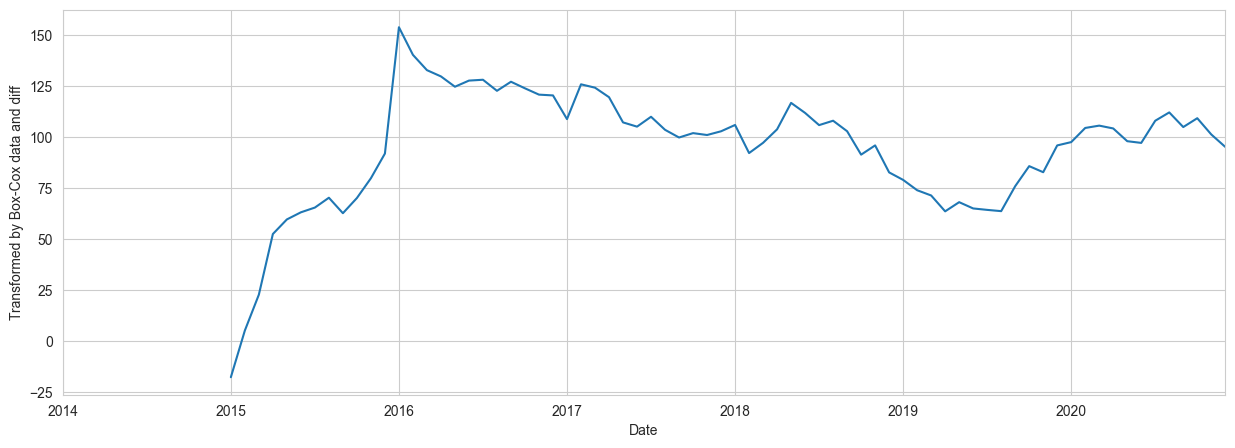

Dickey-Fuller test: p=0.000295


In [13]:
# изменяем параметр shift для сдвига на 12 месяцев
data["deposit_rub_box_diff_12"] = data.deposit_rub_box - data.deposit_rub_box.shift(12)
plt.subplots(figsize=(15, 5))
data.deposit_rub_box_diff_12.plot()
plt.ylabel("Transformed by Box-Cox data and diff")
plt.show()
print(
    "Dickey-Fuller test: p=%f"
    % sm.tsa.stattools.adfuller(data.deposit_rub_box_diff_12[12:])[1]
)
# по результатам теста нулевая гипотеза отвергается и это значит, что ряд стационарен, хотя визуально не очень похоже из-за большого разброса значений на интервале 2015-2016 годов полученного ряда

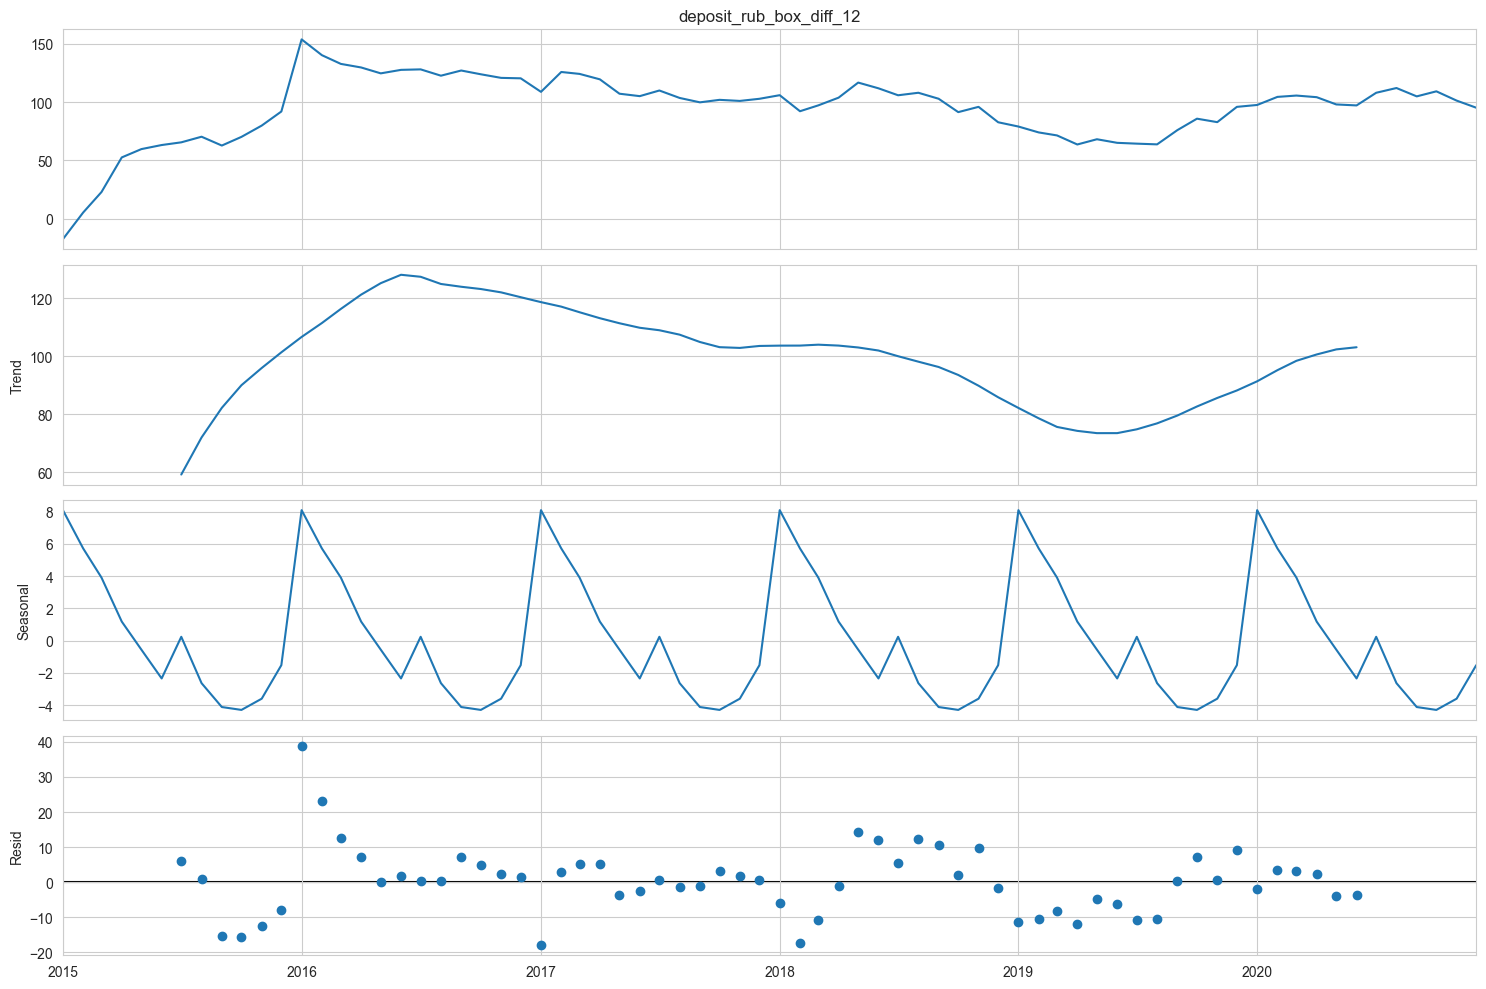

In [14]:
sm.tsa.seasonal_decompose(data.deposit_rub_box_diff_12[12:]).plot()
plt.show()

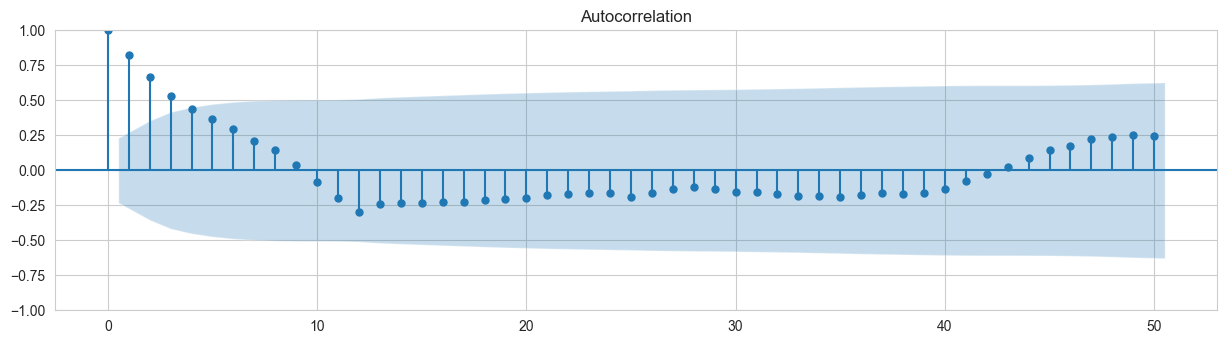

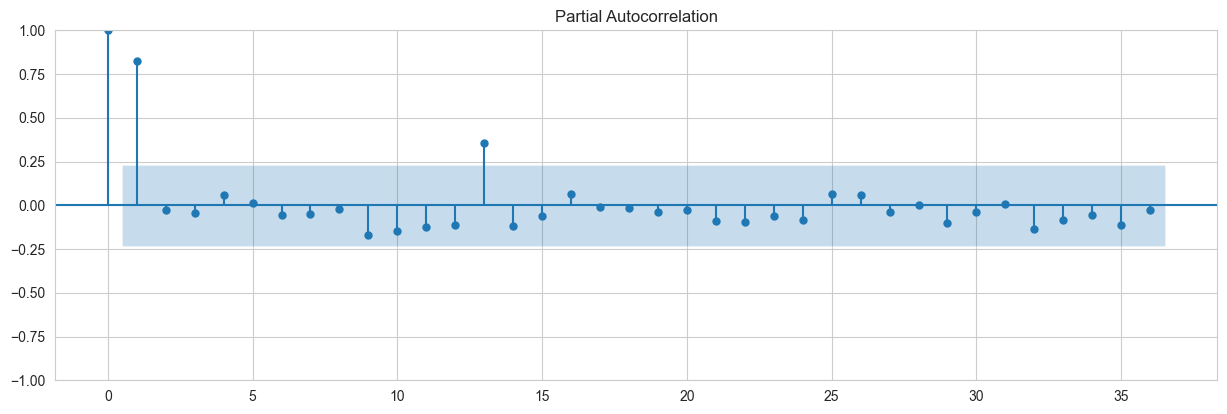

In [15]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize=(15, 8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.deposit_rub_box_diff_12[12:].values.squeeze(), lags=50, ax=ax)
plt.show()

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    data.deposit_rub_box_diff_12[12:].values.squeeze(), lags=36, ax=ax
)
plt.show()

# автокореляция  

## (S)ARIMA model

In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
model = ARIMA(data.deposit_rub_box.round(5), order=(2, 1, 2))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        deposit_rub_box   No. Observations:                   84
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -335.333
Date:                Mon, 07 Oct 2024   AIC                            680.667
Time:                        11:43:42   BIC                            692.761
Sample:                    01-01-2014   HQIC                           685.526
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0001      0.006      0.024      0.981      -0.011       0.011
ar.L2          0.9999      0.005    200.364      0.000       0.990       1.010
ma.L1         -0.0093      0.432     -0.021      0.983      -0.855       0.837
ma.L2         -0.9898      0.136     -7.284      0.000      -1.256      -0.724
sigma2       176.4871      0.003   6.08e+04      0.000     176.481     176.493
===================================================================================
Ljung-Box (L1) (Q):                   2.54   Jarque-Bera (JB):                11.58
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.52
Prob(H) (two-sided):                  0.47   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+21. Standard errors may be unstable.
"""

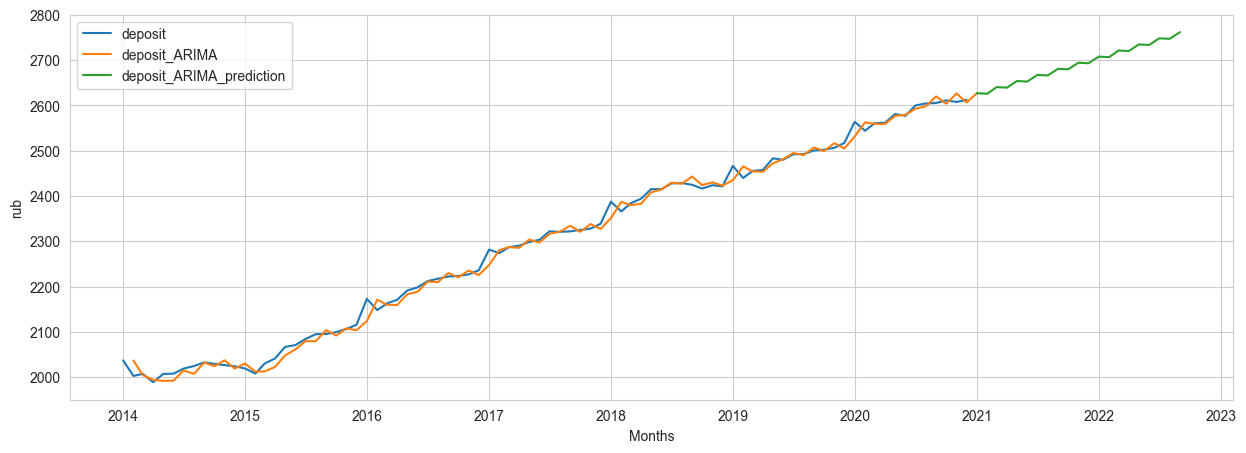

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(data.deposit_rub_box, label="deposit")
plt.plot(res.predict(1, data.shape[0]), label="deposit_ARIMA")
plt.plot(
    res.predict(data.shape[0], data.shape[0] + 20), label="deposit_ARIMA_prediction"
)

plt.legend()
plt.ylabel("rub")
plt.xlabel("Months")
plt.show()

In [19]:
import statsmodels.api as sm

In [20]:
res_sarima = sm.tsa.statespace.SARIMAX(
            data.deposit_rub_box,
            order=(3, 1, 4),
            seasonal_order=(2, 1, 3, 12),
        ).fit(disp=-1)

In [21]:
res_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                            deposit_rub_box   No. Observations:                   84
Model:             SARIMAX(3, 1, 4)x(2, 1, [1, 2, 3], 12)   Log Likelihood                -255.462
Date:                                    Mon, 07 Oct 2024   AIC                            536.924
Time:                                            11:43:46   BIC                            566.339
Sample:                                        01-01-2014   HQIC                           548.621
                                             - 12-01-2020                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3416      0.477     -2.810      0.005      -2.277      -0.406
ar.L2         -1.1155      0.326     -3.426      0.001      -1.754      -0.477
ar.L3         -0.6513      0.322     -2.020      0.043      -1.283      -0.019
ma.L1          1.4754      0.504      2.925      0.003       0.487       2.464
ma.L2          1.6410      1.383      1.186      0.236      -1.070       4.352
ma.L3          1.2462      1.414      0.881      0.378      -1.526       4.018
ma.L4          0.2856      0.465      0.615      0.539      -0.625       1.196
ar.S.L12      -0.8298      5.761     -0.144      0.885     -12.121      10.461
ar.S.L24      -0.2991      1.884     -0.159      0.874      -3.992       3.394
ma.S.L12      -0.4559      8.355     -0.055      0.956     -16.832      15.920
ma.S.L24      -0.2591      4.493     -0.058      0.954      -9.065       8.547
ma.S.L36      -0.1941      1.700     -0.114      0.909      -3.526       3.138
sigma2        51.8012    164.114      0.316      0.752    -269.855     373.458
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):               127.15
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             1.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
res_sarima.predict()

2014-01-01       0.000000
2014-02-01    2036.720667
2014-03-01    2002.526367
2014-04-01    2007.196555
2014-05-01    1988.615233
                 ...     
2020-08-01    2600.020415
2020-09-01    2608.790035
2020-10-01    2606.562548
2020-11-01    2613.963925
2020-12-01    2608.397394
Freq: MS, Name: predicted_mean, Length: 84, dtype: float64

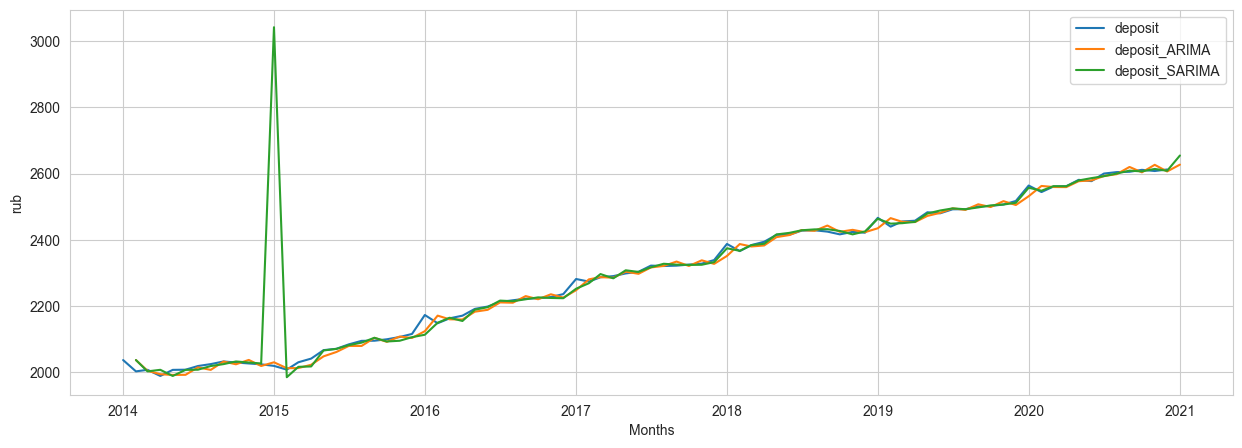

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(data.deposit_rub_box, label="deposit")
plt.plot(res.predict(1, data.shape[0]), label="deposit_ARIMA")
plt.plot(res_sarima.predict(1, data.shape[0]), label="deposit_SARIMA")



plt.legend()
plt.ylabel("rub")
plt.xlabel("Months")
plt.show()

In [24]:
# CODE 2
# Choose parameters for SARIMA model based on Autocorrelation and Partial Autocorrelation graphs

ps = range(0, 2) # AR компонент выбирается при отклонении от порогового значения (синяя область) на графике PACF. В данном случае видно, что значительные отклонения присутствуют только на 1 лаге и сезоном лаге = 12. Но можно добавить еще 1 для эксперимента, поэтому от 0 до 2
d  = 1 # потому что дифиренцирование с лагом 1 уже стационарный ряд и таким образом не сильно разрушаем зависимость в данных
qs = range(0, 2) # Аналогичная ситуация, как с AR, но смотрим на график ACF и видим, что ситуация схожа. Поэтому от 0 до 2
Ps = range(0, 2) # выбираем аналогично AR, но для меньшего числа переборов оставим от 0 до 1
D  = 0 
Qs = range(0, 2) # выбираем аналогично MA, но для меньшего числа переборов оставим от 0 до 1

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print("Number of analysed models:", len(parameters_list))

Number of analysed models: 16


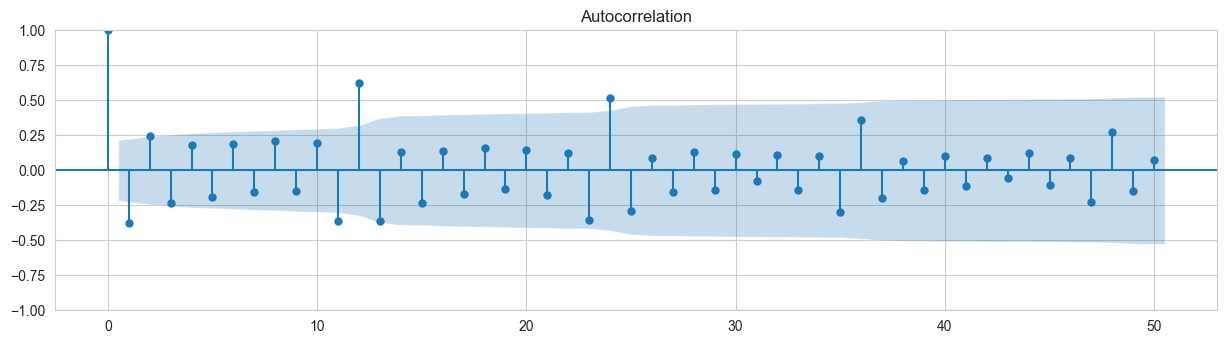
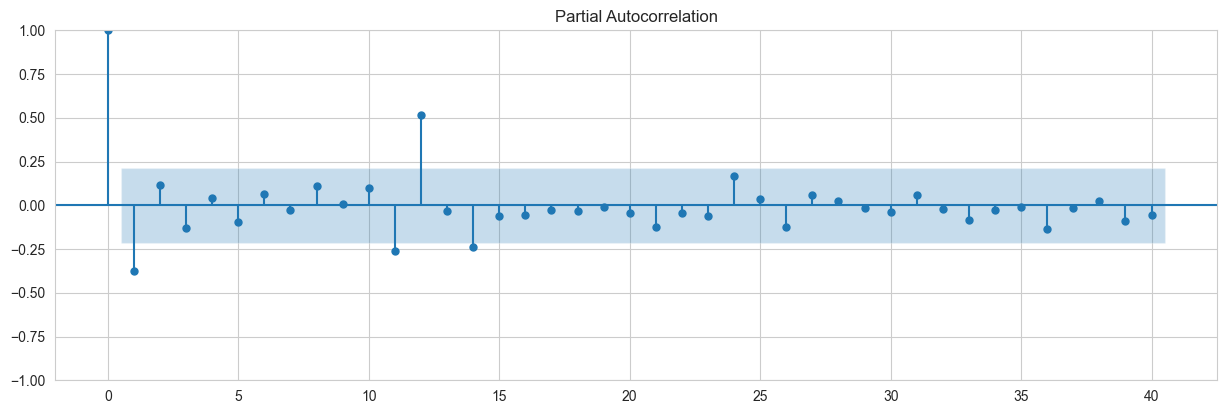

In [25]:
# here we will choose the best model
results = []
best_aic = float("inf")


for param in parameters_list:

    # try except for the case of wrong parameters
    try:
        model = sm.tsa.statespace.SARIMAX(
            data.deposit_rub_box,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12),
        ).fit(disp=-1)

    # print wrong parameters and go on
    # AIC criteria:
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])

In [26]:
# Top models
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by="aic", ascending=True).head())

     parameters         aic
3  (0, 0, 1, 1)  630.264143
2  (0, 0, 1, 0)  640.388274
1  (0, 0, 0, 1)  672.062072
0  (0, 0, 0, 0)  706.954783


In [27]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                      deposit_rub_box   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -312.132
Date:                              Mon, 07 Oct 2024   AIC                            630.264
Time:                                      11:43:48   BIC                            637.521
Sample:                                  01-01-2014   HQIC                           633.179
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9994      0.017     59.086      0.000       0.966       1.033
ma.S.L12      -0.93

In [28]:
# inverse Box-Cox transformation:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)


data["model"] = invboxcox(best_model.fittedvalues, lmbda)

In [29]:
# CODE 3
# Plot the best model and original time series on the same figure

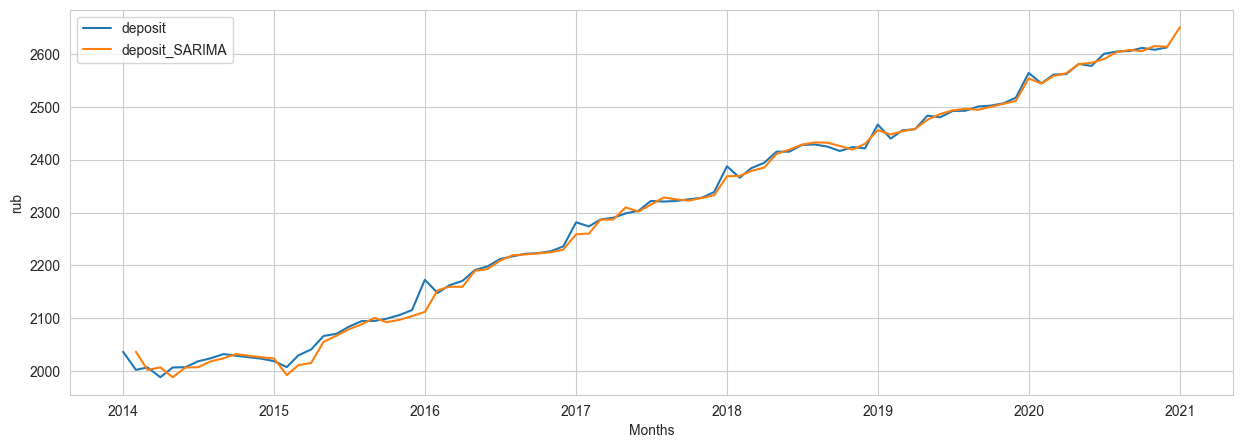

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(data.deposit_rub_box, label="deposit")
plt.plot(best_model.predict(1, data.shape[0]), label="deposit_SARIMA")

plt.legend()
plt.ylabel("rub")
plt.xlabel("Months")
plt.show()

In [31]:
# CODE 4
# Evaluate any metric to check  best model's performance

In [32]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score
print(f"RMSE={root_mean_squared_error(data.deposit_rub_box, best_model.predict(1, data.shape[0])):.2f}")
print(f"MAPE={mean_absolute_percentage_error(data.deposit_rub_box, best_model.predict(1, data.shape[0]))*100:.2f}") 
# так как не содержат нулевые значения, то метрика MAPE применима. И согласно ей результат прогноза весьма точный, т.к. ошибка равна 0.34%. RMSE в целом кажется относительно низким из-за масштаба данных. 

RMSE=12.12
MAPE=0.34


## Additional Time Series

level of inflation

In [33]:
data["Inflation"] = data["Inflation"].apply(lambda x: x.replace(",", ".")).astype(float)

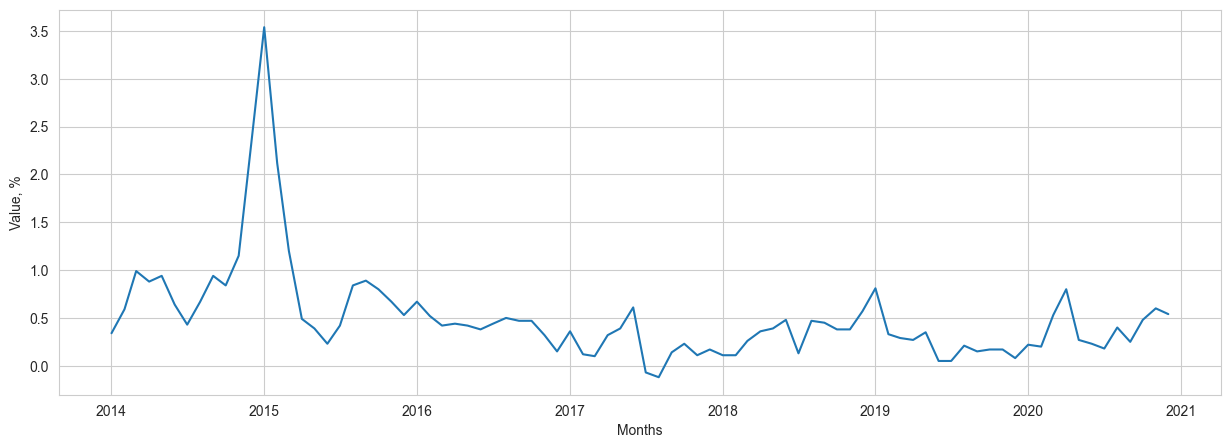

In [34]:
plt.figure(figsize=(15,5))
plt.plot(data.Inflation)
plt.ylabel("Value, %")
plt.xlabel("Months")
plt.show()

In [35]:
# data.head()

usd rate

In [36]:
usd = pd.read_csv("usdrub.csv", sep=";")
usd["Date"] = pd.to_datetime(usd["Date"], format="%d.%m.%Y")
usd["USDRUB"] = usd["USDRUB"].apply(lambda x: x.replace(",", ".")).astype(float)

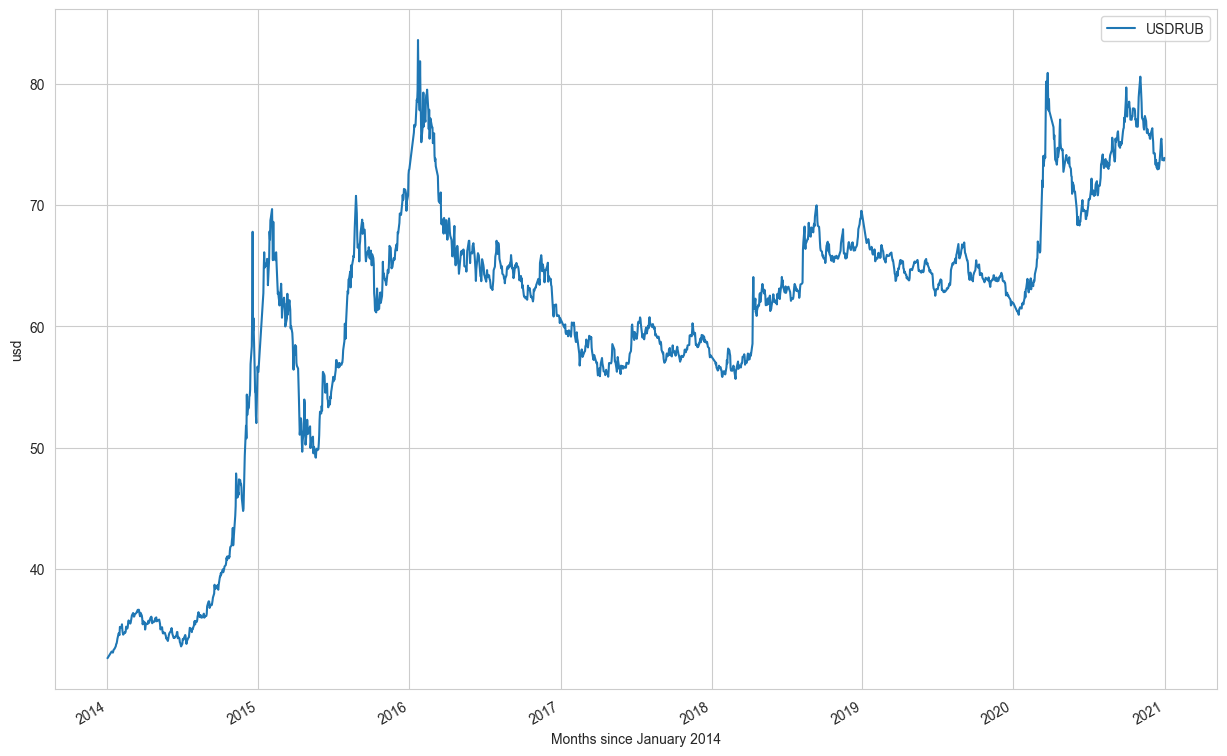

In [37]:
usd.set_index("Date").plot()
plt.ylabel("usd")
plt.xlabel("Months since January 2014")
plt.show()

In [38]:
import datetime

In [39]:
usd["Month"] = usd["Date"].apply(lambda x: datetime.datetime(x.year, x.month, 1))
usd = usd.groupby("Month")["USDRUB"].mean().to_frame()

<Figure size 1500x500 with 0 Axes>

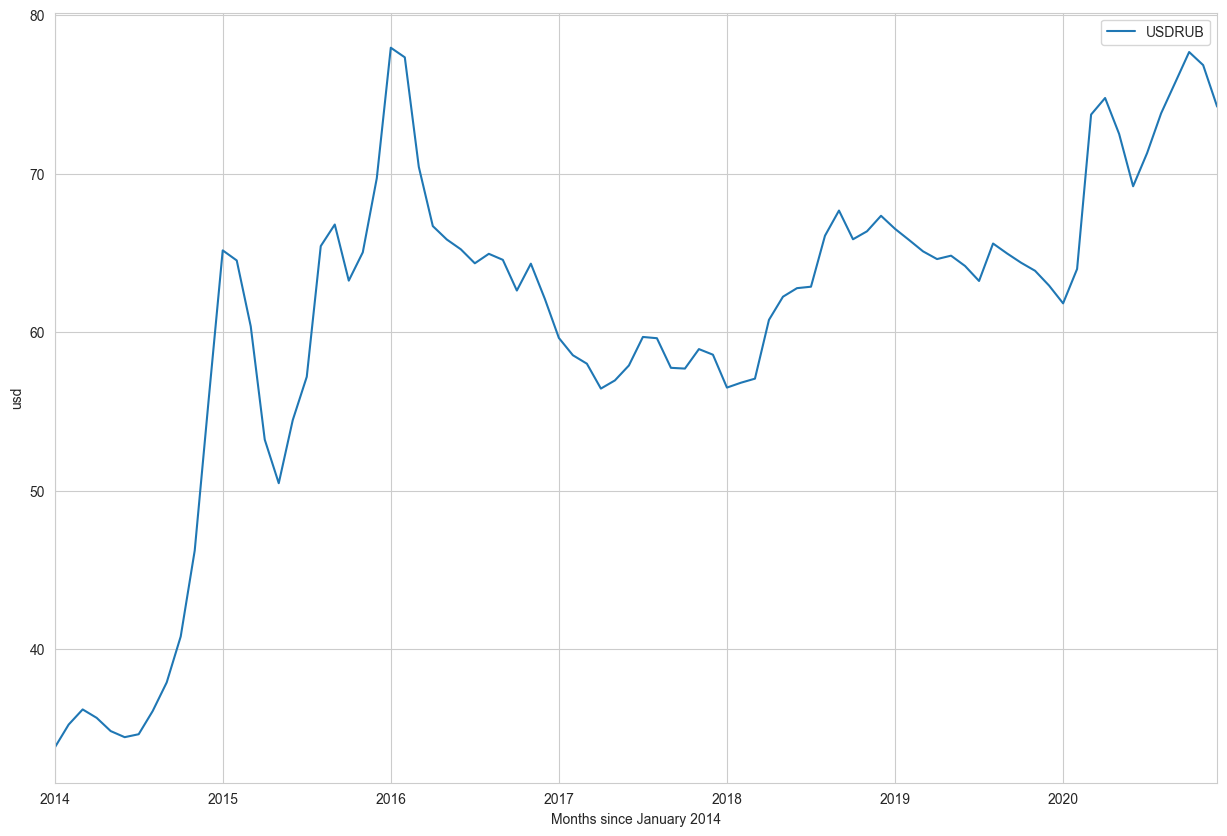

In [40]:
plt.figure(figsize=(15,5))
usd.plot()
plt.ylabel("usd")
plt.xlabel("Months since January 2014")
plt.show()

In [41]:
# https://rosstat.gov.ru/labor_market_employment_salaries
data_wage = pd.read_csv("Wage.csv", sep=";")
data_wage["date"] = pd.to_datetime(data_wage["date"], format="%d.%m.%Y")
data_wage.set_index("date", inplace=True)

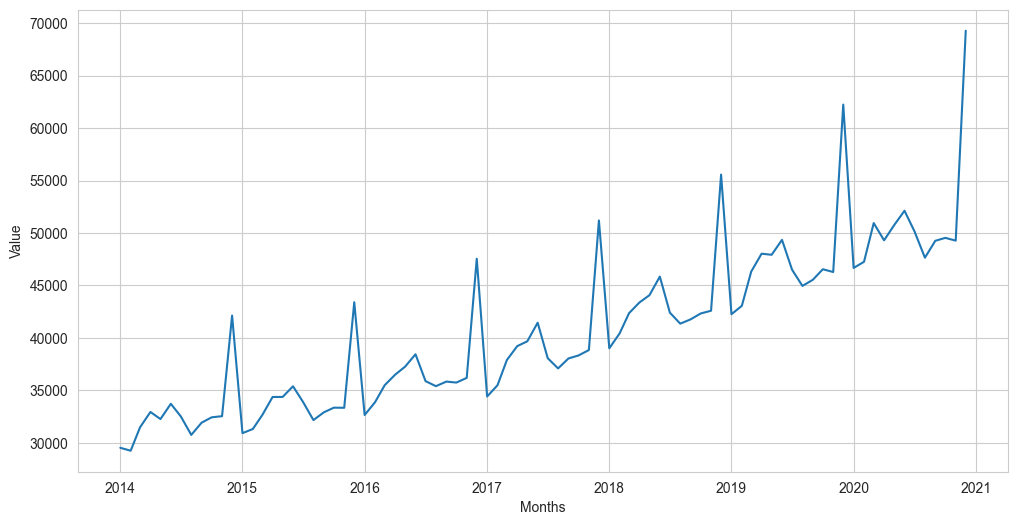

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(data_wage.wage)
plt.ylabel("Value")
plt.xlabel("Months")
plt.show()

In [43]:
def CrossCorr(datax, datay, maxlag=12):
    corr = dict()
    dy = pd.Series(datay)
    for i in range(1, maxlag):
        c = abs(datax.corr(dy.shift(i), method="spearman"))
        corr[i] = c.item()
    return corr

In [44]:
# from statsmodels.tsa.stattools import ccf
# ccf(data.Deposit_rub, usd.USDRUB, adjusted=False,fft=False, nlags=12)

# def CrossCorr(datax, datay, maxlag=12):
#     corr = dict()
#     dy = pd.Series(datay)
    
#     for i in range(-maxlag, maxlag+1):  
#         if i < 0:
#             c = datax.shift(-i).corr(dy, method="pearson")  
#         else:
#             c = datax.corr(dy.shift(i), method="pearson")   
#         corr[i] = c.item()
    
#     return corr
# CrossCorr(data.Deposit_rub, usd.USDRUB, 12)

In [45]:
CrossCorr(data.Deposit_rub, usd.USDRUB)

{1: 0.5735275597162167,
 2: 0.5649372557982608,
 3: 0.5507678410117435,
 4: 0.5425222691045476,
 5: 0.5295034079844206,
 6: 0.5075304442393049,
 7: 0.4973973395026026,
 8: 0.48429254955570744,
 9: 0.46881934566145084,
 10: 0.4503961495742317,
 11: 0.45896581513019874}

In [46]:
CrossCorr(data.Deposit_rub, data.Inflation)

{1: 0.5484949621388631,
 2: 0.5803645944103593,
 3: 0.6008651723693677,
 4: 0.5965837998356807,
 5: 0.6074094112489161,
 6: 0.6098307786798793,
 7: 0.6031831797128332,
 8: 0.6035881020327934,
 9: 0.6406237994326204,
 10: 0.6731894709509715,
 11: 0.6683949274886994}

In [47]:
CrossCorr(data.Deposit_rub, data_wage.wage)

{1: 0.9150959237647454,
 2: 0.9020907478151087,
 3: 0.9068879855465221,
 4: 0.905672761368964,
 5: 0.9052823758519962,
 6: 0.9007827615422552,
 7: 0.9042536410957464,
 8: 0.8962132604237867,
 9: 0.8922332859174964,
 10: 0.88584968530174,
 11: 0.8840861409354561}

In [48]:
import statsmodels.api as sm

In [49]:
# GrangerTest
x = pd.DataFrame()
x["res"] = data.Deposit_rub
x["cause"] = usd.USDRUB
gr_test = sm.tsa.stattools.grangercausalitytests(x, maxlag=12, verbose=False)
p1=min([gr_test[j][0]['ssr_ftest'][1] for j in gr_test])
print(p1)
# gr_test

0.00040085914546363505


## VAR model

In [50]:
from statsmodels.tsa.api import VAR

In [51]:
data_var = pd.concat(
    [data.Deposit_rub, data.Inflation, usd.USDRUB, data_wage.wage], axis=1
)

In [52]:
data_var

,Deposit_rub,Inflation,USDRUB,wage
2014-01-01,14000569.00,0.34,33.784118,29535
2014-02-01,13433121.00,0.59,35.244500,29255
2014-03-01,13510318.00,0.99,36.199000,31486
2014-04-01,13206977.00,0.88,35.667727,32947
2014-05-01,13507416.00,0.94,34.834500,32272
...,...,...,...,...
2020-08-01,25534027.52,0.40,73.799524,47649
2020-09-01,25557608.90,0.25,75.726818,49259
2020-10-01,25699001.52,0.48,77.663478,49539
2020-11-01,25613765.36,0.60,76.838947,49274


In [53]:
base_aic = np.float64('inf')
for i in range(1,6): # [1, 2, 3, 4, 5]:
    model = VAR(data_var)
    results = model.fit(i)
    print("Order =", i)
    print("AIC: ", results.aic)
    if results.aic < base_aic:
        print('AIC')
#     print("BIC: ", results.bic)
    print()

Order = 1
AIC:  40.570439008970766
AIC

Order = 2
AIC:  39.587288824088816
AIC

Order = 3
AIC:  39.68069016229837
AIC

Order = 4
AIC:  39.68459458589596
AIC

Order = 5
AIC:  39.62809212844385
AIC



In [54]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Oct, 2024
Time:                     11:43:50
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    42.1475
Nobs:                     79.0000    HQIC:                   40.6374
Log likelihood:          -1929.69    FPE:                1.70996e+17
AIC:                      39.6281    Det(Omega_mle):     6.66032e+16
--------------------------------------------------------------------
Results for equation Deposit_rub
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const            -472579.402142    207889.299115           -2.273           0.023
L1.Deposit_rub         0.682576         0.139943            4.878           0.000
L1.Inflation     -192405.776332     84013.926648  

In [55]:
# results.plot()

In [56]:
# plt.plot()
results.forecast(data_var.values, 5)[:,0]

array([26986521.36316094, 26577611.63018627, 27118516.48016387,
       27028834.49848563, 27251674.86578326])

## Задание 5

In [57]:
# CODE 5

# Compare forecast quality for ARIMA/SARIMA/VAR models 
# You can divided all data on two dataset (train and test)

In [58]:
# я сравню модели с помощью кросс-валидации
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [59]:
results_df = pd.DataFrame(columns = ['Model','Fold','R2_score','RMSE','MAPE'])
row_inx = 0

results_df

,Model,Fold,R2_score,RMSE,MAPE


Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Test:  index=[14 15 16 17 18 19 20 21 22 23 24 25 26 27]


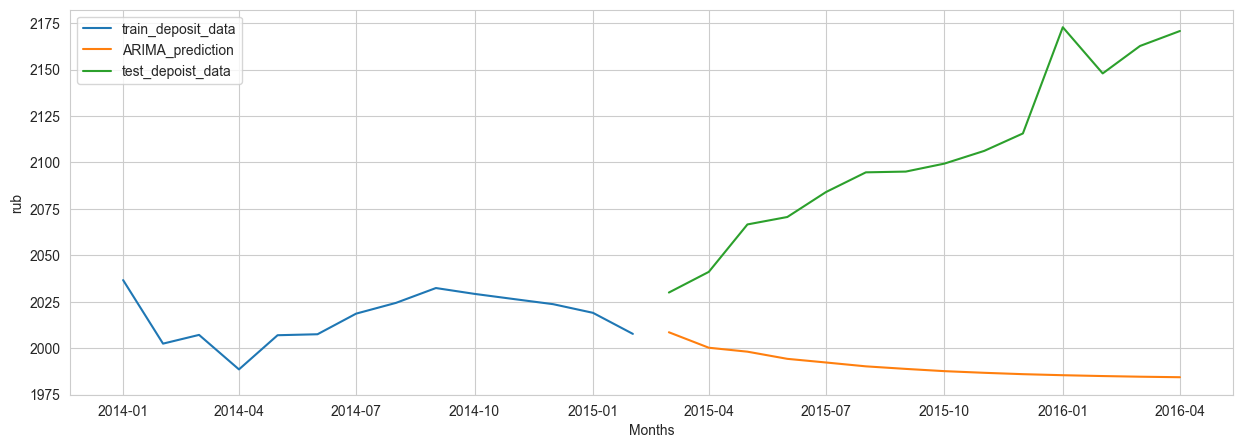

Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
  Test:  index=[28 29 30 31 32 33 34 35 36 37 38 39 40 41]


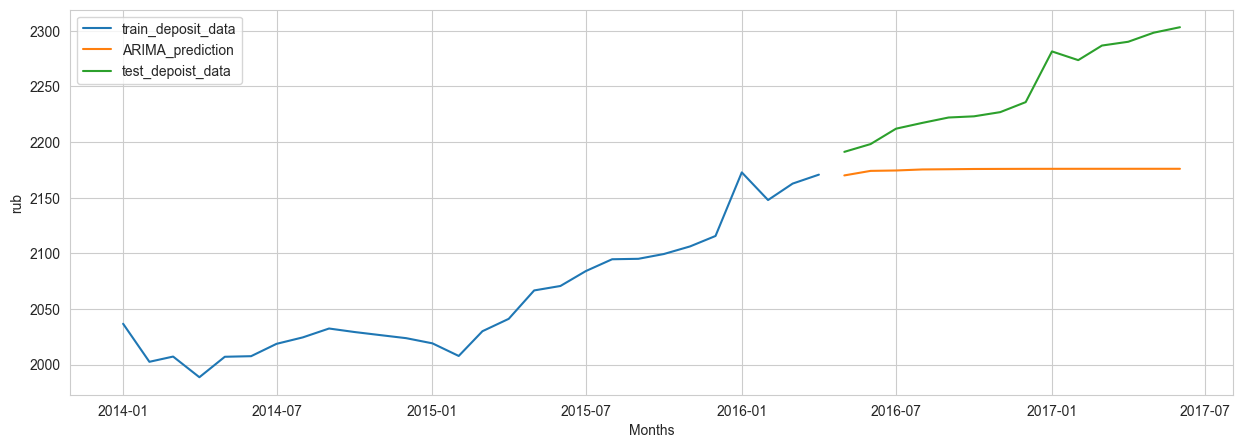

Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
  Test:  index=[42 43 44 45 46 47 48 49 50 51 52 53 54 55]


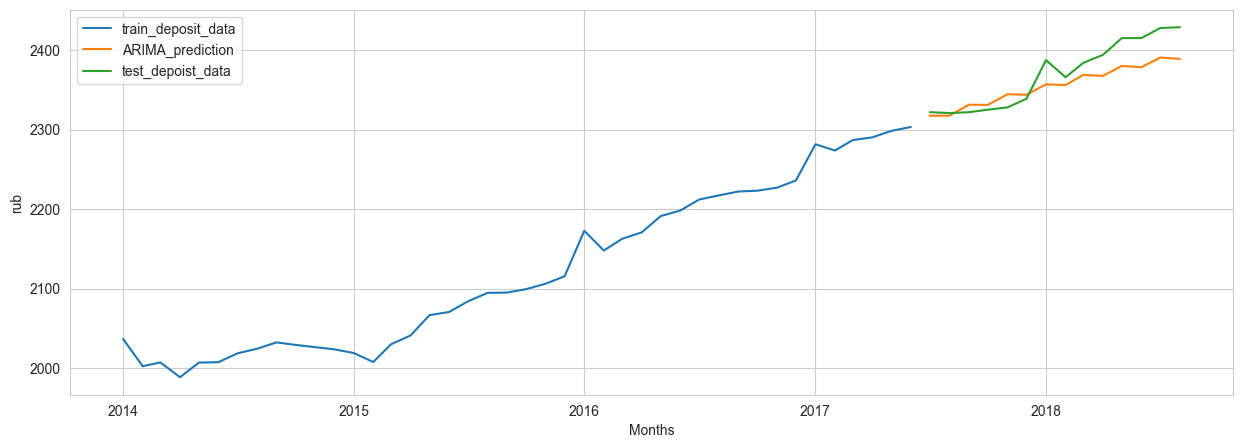

Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
  Test:  index=[56 57 58 59 60 61 62 63 64 65 66 67 68 69]


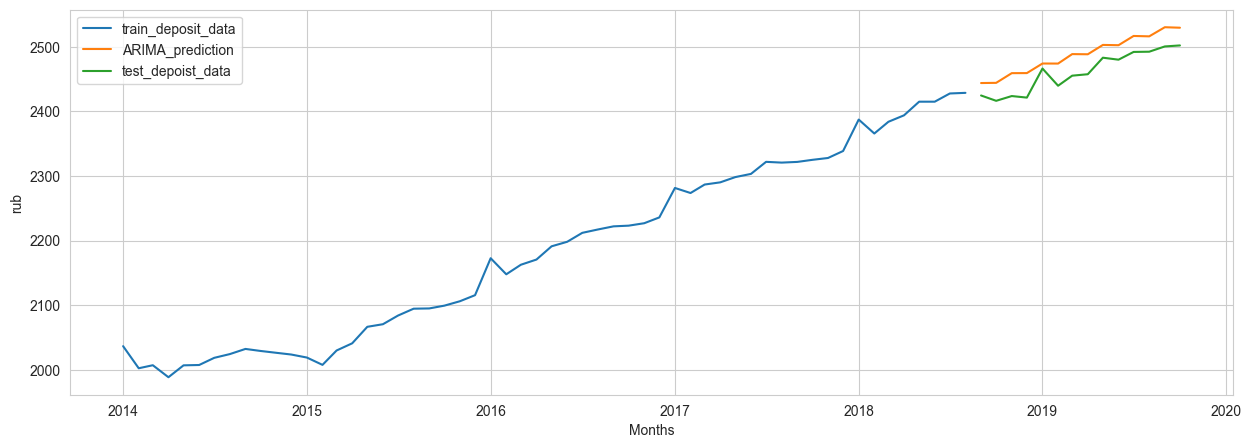

Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
  Test:  index=[70 71 72 73 74 75 76 77 78 79 80 81 82 83]


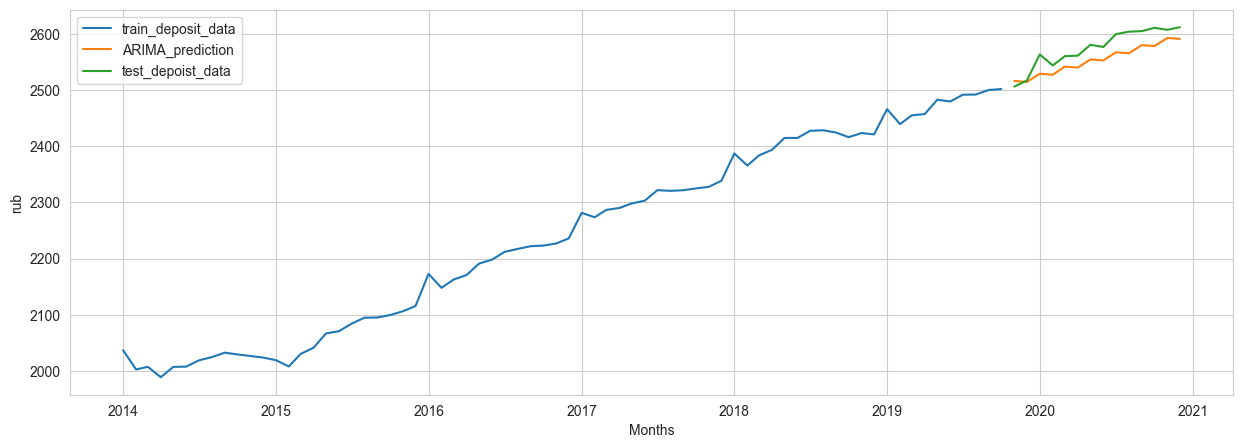

,Model,Fold,R2_score,RMSE,MAPE
0,ARIMA,0,-6.888955,123.858804,0.053315
1,ARIMA,1,-3.494374,81.053468,0.031751
2,ARIMA,2,0.665481,23.820096,0.008212
3,ARIMA,3,0.155714,27.836141,0.010886
4,ARIMA,4,0.461137,24.597132,0.00876


In [60]:
# ARIMA
X = data.deposit_rub_box

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    # делим данные 
    train_data, test_data = X[train_index],X[test_index]
    # обучаем модели
    model = ARIMA(train_data.round(5), order=(2, 1, 2))
    res = model.fit()
    res.summary()
    # визуализация результата
    plt.figure(figsize=(15, 5))
    plt.plot(X[train_index], label="train_deposit_data")
    plt.plot(res.predict(test_index.min(), test_index.max()), label="ARIMA_prediction")
    plt.plot(X[test_index], label="test_depoist_data")
    
    plt.legend()
    plt.ylabel("rub")
    plt.xlabel("Months")
    plt.show()
    # фиксируем результаты
    results_df.loc[row_inx, 'Model'] = 'ARIMA'
    results_df.loc[row_inx, 'Fold'] = i
    results_df.loc[row_inx, 'R2_score'] = r2_score(X[test_index], res.predict(test_index.min(), test_index.max()))
    results_df.loc[row_inx, 'RMSE'] = root_mean_squared_error(X[test_index], res.predict(test_index.min(), test_index.max()))
    results_df.loc[row_inx, 'MAPE'] = mean_absolute_percentage_error(X[test_index], res.predict(test_index.min(), test_index.max()))
    
    row_inx += 1

results_df

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Test:  index=[14 15 16 17 18 19 20 21 22 23 24 25 26 27]


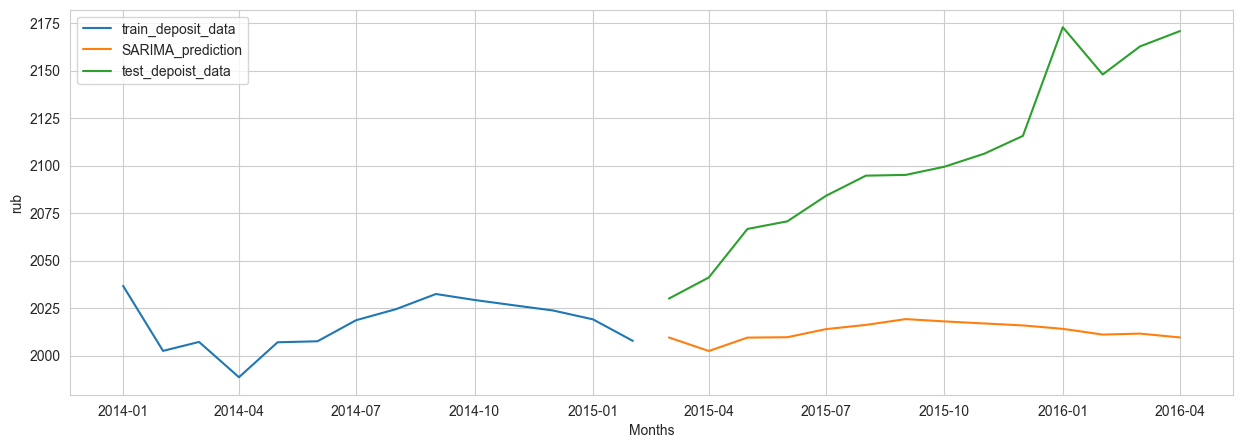

Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
  Test:  index=[28 29 30 31 32 33 34 35 36 37 38 39 40 41]


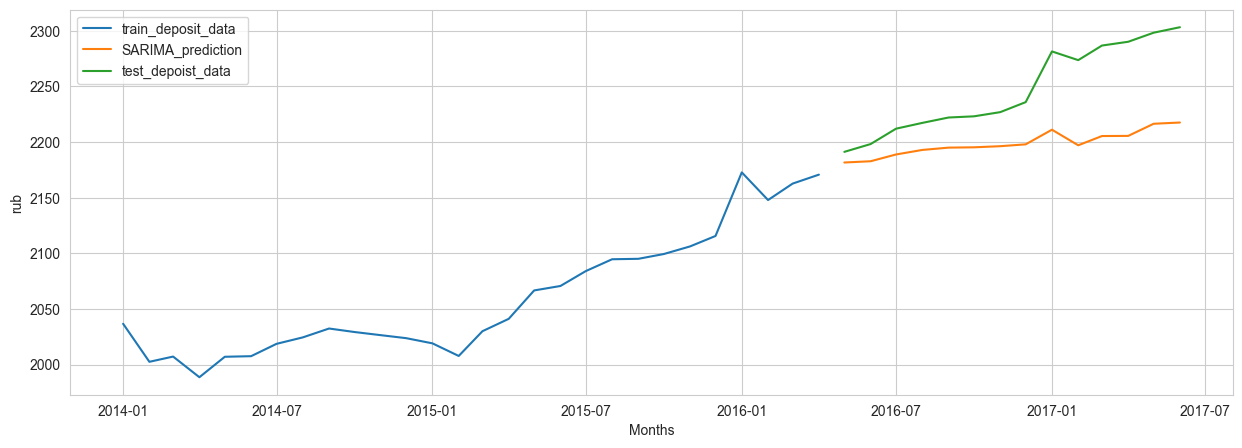

Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
  Test:  index=[42 43 44 45 46 47 48 49 50 51 52 53 54 55]


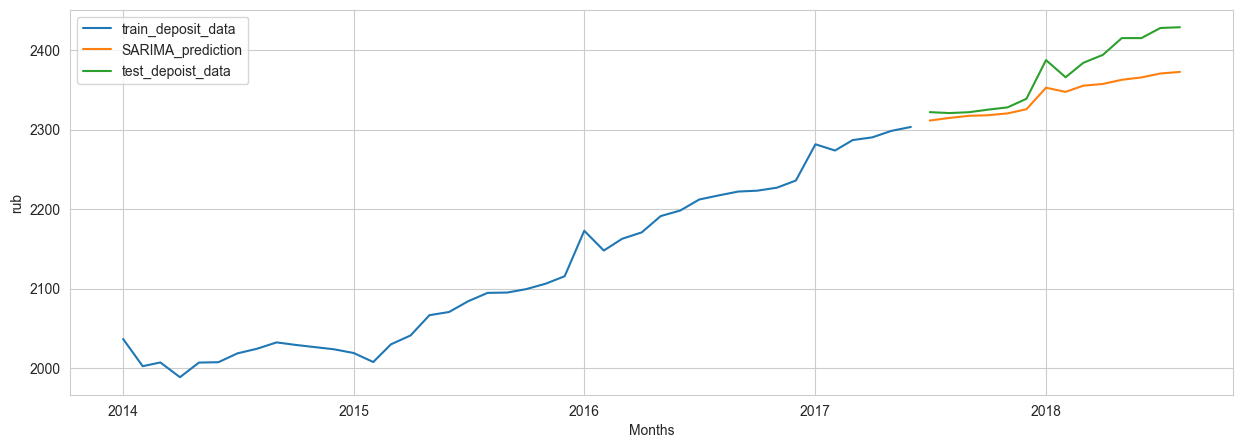

Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
  Test:  index=[56 57 58 59 60 61 62 63 64 65 66 67 68 69]


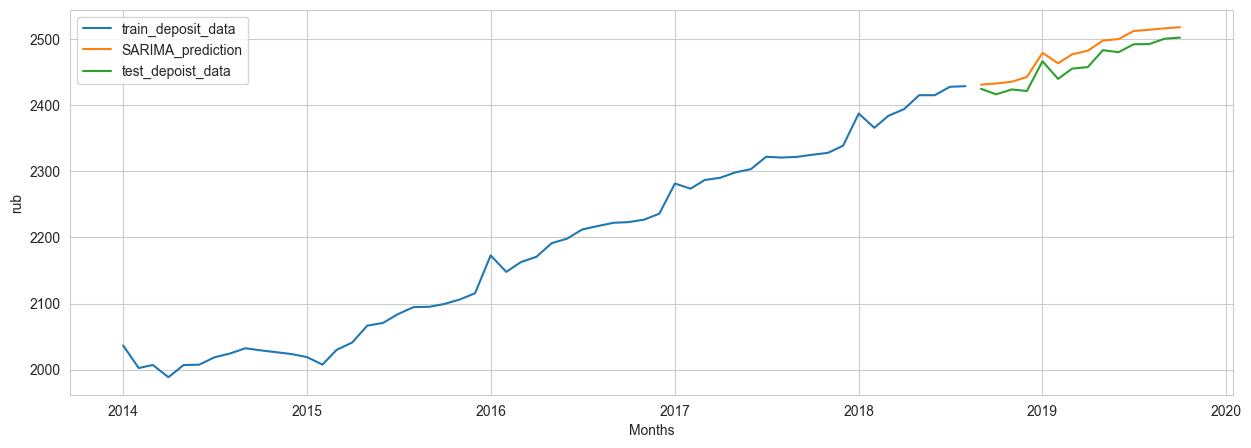

Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
  Test:  index=[70 71 72 73 74 75 76 77 78 79 80 81 82 83]


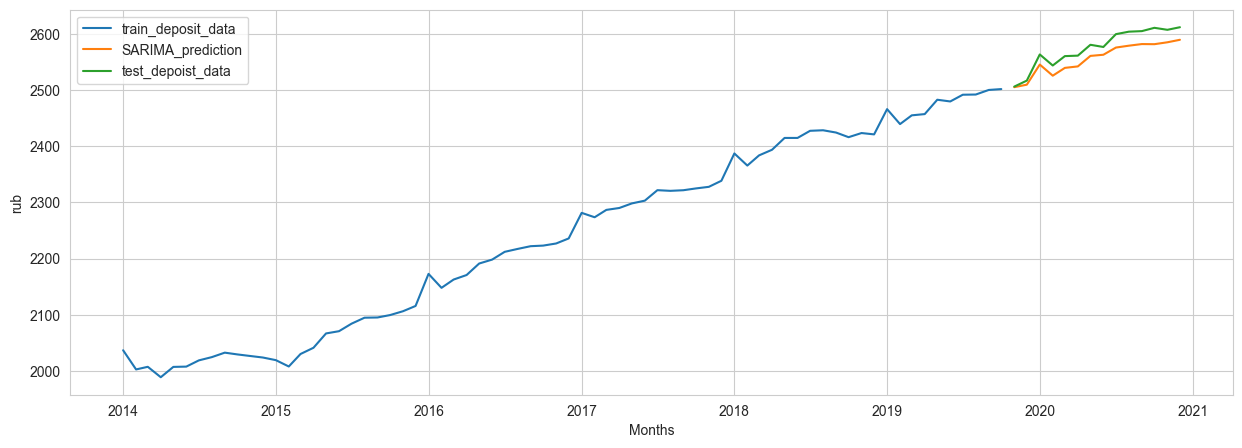

,Model,Fold,R2_score,RMSE,MAPE
0,ARIMA,0,-6.888955,123.858804,0.053315
1,ARIMA,1,-3.494374,81.053468,0.031751
2,ARIMA,2,0.665481,23.820096,0.008212
3,ARIMA,3,0.155714,27.836141,0.010886
4,ARIMA,4,0.461137,24.597132,0.00876
5,SARIMA,0,-4.253824,101.077594,0.043051
6,SARIMA,1,-1.149072,56.048309,0.021295
7,SARIMA,2,0.335347,33.576141,0.011399
8,SARIMA,3,0.637123,18.249207,0.007131
9,SARIMA,4,0.639111,20.129456,0.007291


In [61]:
# SARIMA использовалась лучшая модель на предыдущих шагах
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    # делим данные 
    train_data, test_data = X[train_index],X[test_index]
    # обучаем модели
    model = sm.tsa.statespace.SARIMAX(
            train_data,
            order=(0, 1, 0),
            seasonal_order=(1, 0, 1, 12),
        ).fit(disp=-1)
    model.summary()

    predictions = model.predict(test_index.min(), test_index.max())

    # визуализация результата
    plt.figure(figsize=(15, 5))
    plt.plot(X[train_index], label="train_deposit_data")
    plt.plot(predictions, label="SARIMA_prediction")
    plt.plot(X[test_index], label="test_depoist_data")
    
    plt.legend()
    plt.ylabel("rub")
    plt.xlabel("Months")
    plt.show()
    # фиксируем результаты
    results_df.loc[row_inx, 'Model'] = 'SARIMA'
    results_df.loc[row_inx, 'Fold'] = i
    results_df.loc[row_inx, 'R2_score'] = r2_score(X[test_index], predictions)
    results_df.loc[row_inx, 'RMSE'] = root_mean_squared_error(X[test_index],predictions)
    results_df.loc[row_inx, 'MAPE'] = mean_absolute_percentage_error(X[test_index], predictions)
    
    row_inx += 1

results_df

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Test:  index=[14 15 16 17 18 19 20 21 22 23 24 25 26 27]
2015-03-01    2009.957534
2015-04-01    2011.926216
2015-05-01    2012.784216
2015-06-01    2013.161310
2015-07-01    2013.327021
2015-08-01    2013.399841
2015-09-01    2013.431842
2015-10-01    2013.445904
2015-11-01    2013.452084
2015-12-01    2013.454800
2016-01-01    2013.455993
2016-02-01    2013.456517
2016-03-01    2013.456748
2016-04-01    2013.456849
dtype: float64


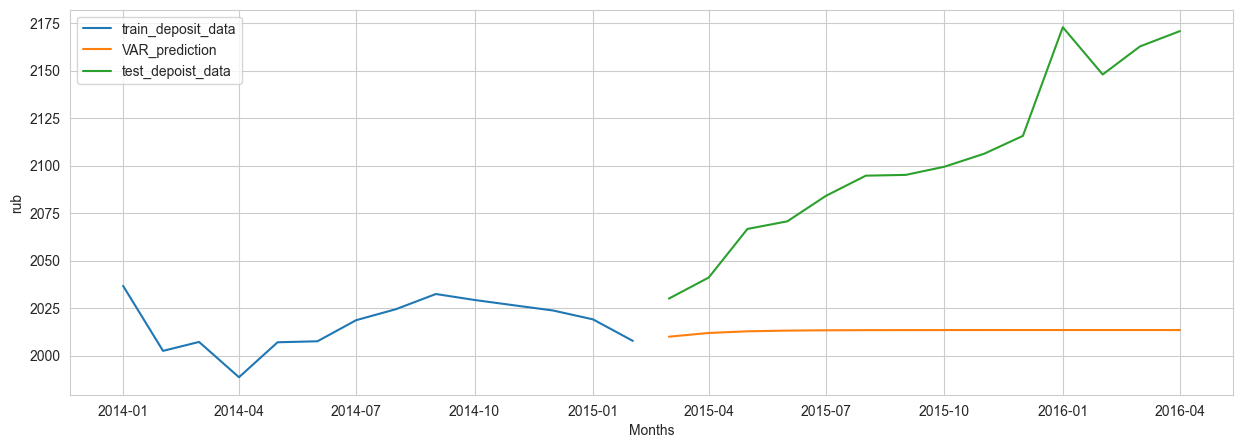

Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
  Test:  index=[28 29 30 31 32 33 34 35 36 37 38 39 40 41]
2016-05-01    2182.277453
2016-06-01    2191.575685
2016-07-01    2201.488991
2016-08-01    2211.693183
2016-09-01    2222.238594
2016-10-01    2233.131676
2016-11-01    2244.384477
2016-12-01    2256.008805
2017-01-01    2268.016937
2017-02-01    2280.421543
2017-03-01    2293.235713
2017-04-01    2306.472971
2017-05-01    2320.147285
2017-06-01    2334.273086
dtype: float64


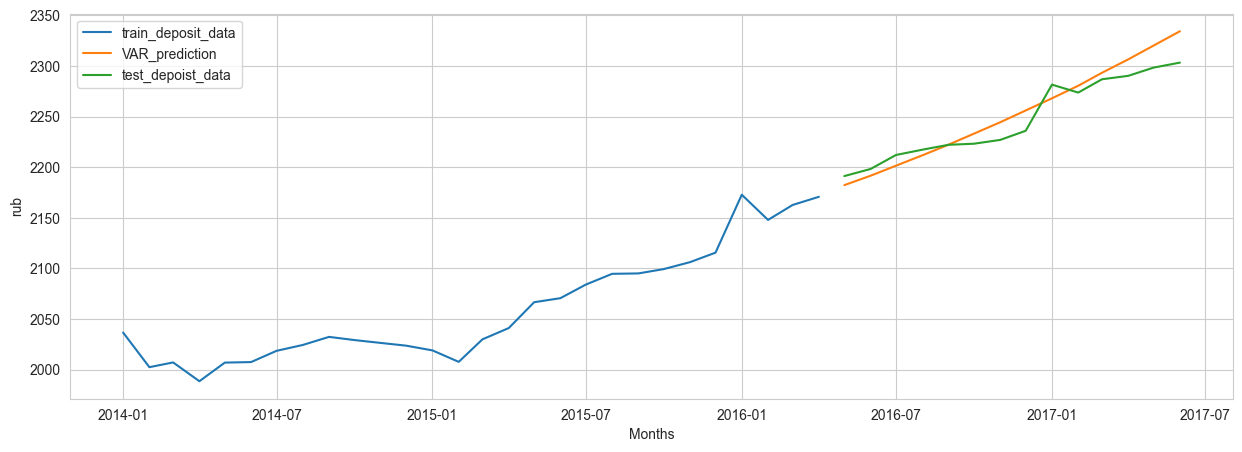

Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
  Test:  index=[42 43 44 45 46 47 48 49 50 51 52 53 54 55]
2017-07-01    2322.085924
2017-08-01    2332.342492
2017-09-01    2344.218217
2017-10-01    2356.143494
2017-11-01    2368.368452
2017-12-01    2380.861162
2018-01-01    2393.633592
2018-02-01    2406.691057
2018-03-01    2420.040066
2018-04-01    2433.687106
2018-05-01    2447.638833
2018-06-01    2461.902049
2018-07-01    2476.483710
2018-08-01    2491.390925
dtype: float64


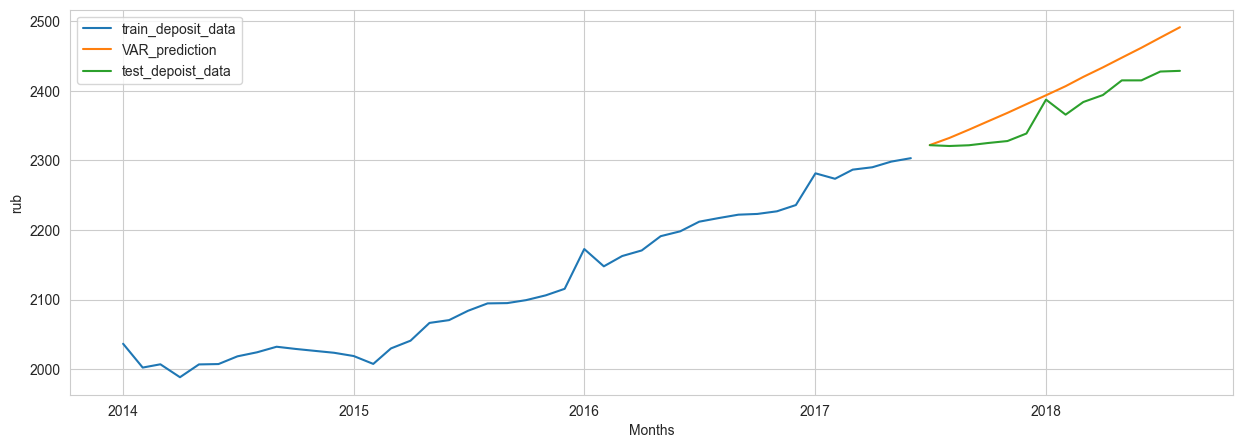

Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
  Test:  index=[56 57 58 59 60 61 62 63 64 65 66 67 68 69]
2018-09-01    2434.204262
2018-10-01    2444.737370
2018-11-01    2454.694275
2018-12-01    2464.851561
2019-01-01    2475.103259
2019-02-01    2485.465298
2019-03-01    2495.936783
2019-04-01    2506.519157
2019-05-01    2517.213556
2019-06-01    2528.021171
2019-07-01    2538.943199
2019-08-01    2549.980852
2019-09-01    2561.135354
2019-10-01    2572.407941
dtype: float64


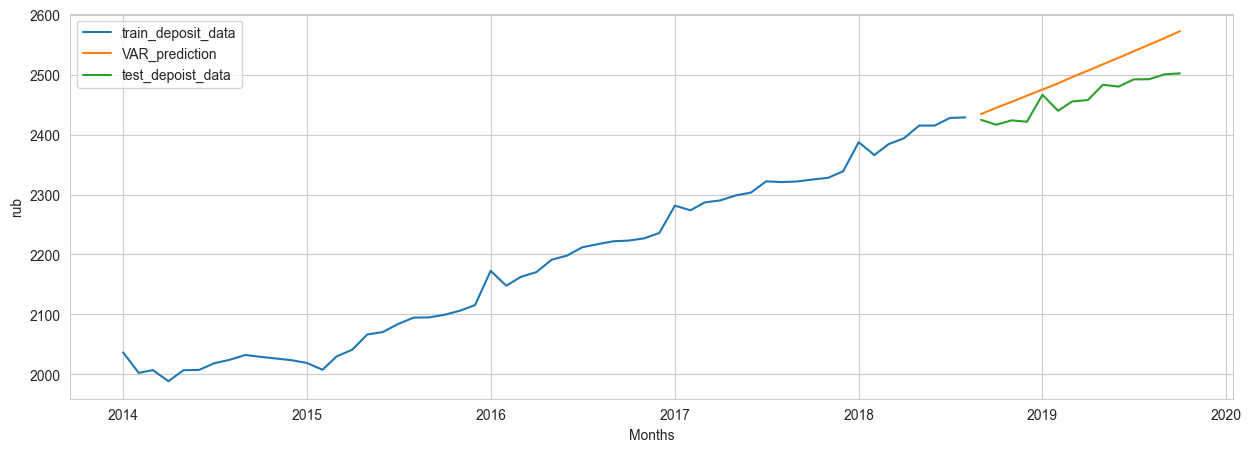

Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
  Test:  index=[70 71 72 73 74 75 76 77 78 79 80 81 82 83]
2019-11-01    2511.447984
2019-12-01    2518.974977
2020-01-01    2526.703907
2020-02-01    2534.437522
2020-03-01    2542.195142
2020-04-01    2549.974952
2020-05-01    2557.777199
2020-06-01    2565.601932
2020-07-01    2573.449215
2020-08-01    2581.319114
2020-09-01    2589.211694
2020-10-01    2597.127020
2020-11-01    2605.065159
2020-12-01    2613.026175
dtype: float64


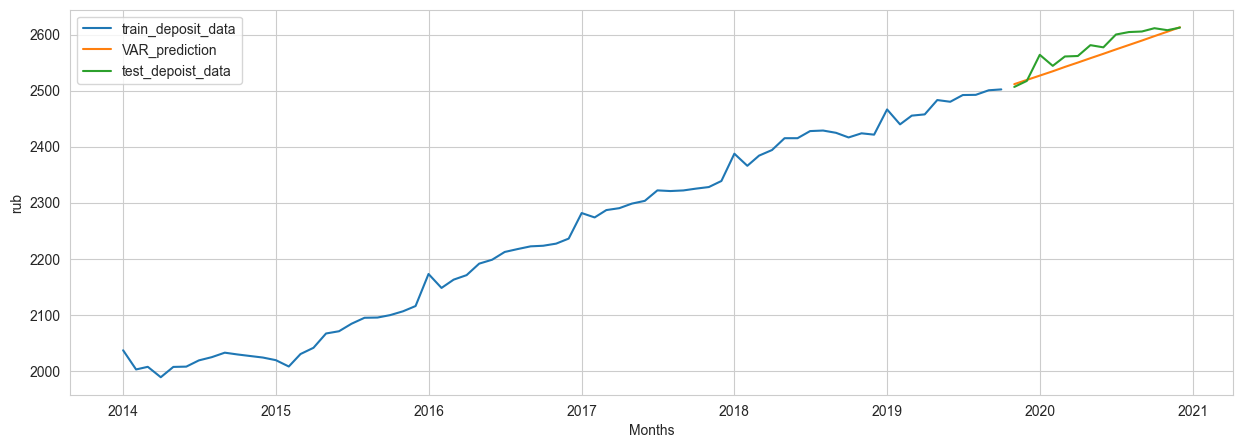

,Model,Fold,R2_score,RMSE,MAPE
0,ARIMA,0,-6.888955,123.858804,0.053315
1,ARIMA,1,-3.494374,81.053468,0.031751
2,ARIMA,2,0.665481,23.820096,0.008212
3,ARIMA,3,0.155714,27.836141,0.010886
4,ARIMA,4,0.461137,24.597132,0.00876
5,SARIMA,0,-4.253824,101.077594,0.043051
6,SARIMA,1,-1.149072,56.048309,0.021295
7,SARIMA,2,0.335347,33.576141,0.011399
8,SARIMA,3,0.637123,18.249207,0.007131
9,SARIMA,4,0.639111,20.129456,0.007291


In [62]:
# Обучение VAR
X1 = pd.concat(
    [data.deposit_rub_box, data_wage.wage], axis=1
)

# VAR модель была определена согласно кросс-корреляции и в качестве фактора для улучшения прогноов выбран наибоолее коррелированный признак wage. Лаг выбран согласно наибольшего значения кросс-корреляции по признаку wage
for i, (train_index, test_index) in enumerate(tscv.split(X1)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    # делим данные 
    train_data, test_data = X1.iloc[train_index,:],X1.iloc[test_index,:]

    best_rmse=np.float64('inf')
    
    # обучаем модели
    result_var = VAR(train_data)
    results_model = result_var.fit(1)
    predictions = results_model.forecast(train_data.values, len(test_index))[:,0]
    y_test = test_data['deposit_rub_box']
    y_pred = pd.Series(predictions, index = y_test.index)
    print(y_pred)

    # визуализация результата
    plt.figure(figsize=(15, 5))
    plt.plot(train_data['deposit_rub_box'], label="train_deposit_data")
    plt.plot(y_pred, label="VAR_prediction")
    plt.plot(y_test, label="test_depoist_data")
    
    plt.legend()
    plt.ylabel("rub")
    plt.xlabel("Months")
    plt.show()
    # фиксируем результаты
    results_df.loc[row_inx, 'Model'] = 'VAR'
    results_df.loc[row_inx, 'Fold'] = i
    results_df.loc[row_inx, 'R2_score'] = r2_score(y_test, y_pred)
    results_df.loc[row_inx, 'RMSE'] = root_mean_squared_error(y_test,y_pred)
    results_df.loc[row_inx, 'MAPE'] = mean_absolute_percentage_error(y_test, y_pred)
    
    row_inx += 1

results_df

In [63]:
# results_df.sort_values('R2_score', ascending=False)
# results_df.sort_values('MAPE', ascending=True)
results_df.sort_values('RMSE', ascending=True)

,Model,Fold,R2_score,RMSE,MAPE
11,VAR,1,0.851382,14.739141,0.005533
14,VAR,4,0.722329,17.656727,0.005591
8,SARIMA,3,0.637123,18.249207,0.007131
9,SARIMA,4,0.639111,20.129456,0.007291
2,ARIMA,2,0.665481,23.820096,0.008212
4,ARIMA,4,0.461137,24.597132,0.00876
3,ARIMA,3,0.155714,27.836141,0.010886
7,SARIMA,2,0.335347,33.576141,0.011399
12,VAR,2,0.192669,37.004889,0.013849
13,VAR,3,-1.144865,44.367433,0.016608


В зависимости от выбора метрики можно получить два варианта:
1. MAPE и RMSE показывают, что модель VAR наиболее точно приближает данные с достаточным кол-вом данных. В то время как модели SARIMA и ARIMA бывают более устойчивы. Важно отметить, что кол-во данных для обучения также влияют на результат. В случае со всеми моделями чем больше, тем меньше ошибка. Исключение это 2020 и 2021, когда везде вводились ковидные ограничения.
2. По r2 получилось, что модель VAR оказалась более точной, что может быть связано не только с общей точностью модели, но и способе вычисления модели (по умолчанию ols)

## Задача 6

In [64]:
# CODE 6

# Choose any addition financial time series.
# Calculate crosscorrelatioin/grangercausalitytests
# Add this time series to the model.
# Compare forecast quality.

In [65]:
X1

,deposit_rub_box,wage
2014-01-01,2036.689760,29535
2014-02-01,2002.495261,29255
2014-03-01,2007.196717,31486
2014-04-01,1988.629980,32947
2014-05-01,2007.020267,32272
...,...,...
2020-08-01,2604.401221,47649
2020-09-01,2605.384984,49259
2020-10-01,2611.272343,49539
2020-11-01,2607.725547,49274


In [66]:
import pandas as pd

url = "https://cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2014&UniDbQuery.To=31.12.2020"
tables = pd.read_html(url)
print(tables[0])

            Дата  Ставка
0     31.12.2020     425
1     30.12.2020     425
2     29.12.2020     425
3     28.12.2020     425
4     25.12.2020     425
...          ...     ...
1730  15.01.2014     550
1731  14.01.2014     550
1732  13.01.2014     550
1733  10.01.2014     550
1734  09.01.2014     550

[1735 rows x 2 columns]


In [67]:
df_add1 = tables[0].rename({'Дата':'date', 'Ставка':'cb_rate'}, axis=1)
df_add1['date_datetime'] = pd.to_datetime(df_add1['date'])
df_add1['cb_rate'] /= 100

df_add1 = df_add1.sort_values('date_datetime').reset_index(drop=True)
df_add1['day'] = df_add1['date_datetime'].apply(lambda x: x.day)
df_add1['month'] = df_add1['date_datetime'].apply(lambda x: x.month)
df_add1['year'] = df_add1['date_datetime'].apply(lambda x: x.year)

df_itog = pd.DataFrame(columns=['date','cb_rate'])

for (month,year), group in df_add1.groupby(['month', 'year']):
    # если есть запись от 1-го числа, то ее добавляем
    if group[group.day==1] is None:
        group.loc[group.day==1, ['date','cb_rate']]
        df_itog = pd.concat([df_itog,group])
    # если записи нет, то добавляем ближайшее число
    else:
        df_new = group.loc[group.day==np.min(group.day)]
        df_new['date'] = pd.Timestamp(day=1, month = int(df_new.month), year=int(df_new.year))
        df_itog = pd.concat([df_itog,df_new[['date','cb_rate']]])

df_itog = df_itog.set_index('date')
df_itog

,cb_rate
date,
2014-01-01,5.50
2015-01-01,17.00
2016-01-01,11.00
2017-01-01,10.00
2018-01-01,7.75
...,...
2016-12-01,10.00
2017-12-01,8.25
2018-12-01,7.50


In [68]:
X2 = pd.concat(
    [X1, df_itog.cb_rate], axis=1
)
X2

,deposit_rub_box,wage,cb_rate
2014-01-01,2036.689760,29535,5.50
2014-02-01,2002.495261,29255,5.50
2014-03-01,2007.196717,31486,7.00
2014-04-01,1988.629980,32947,7.00
2014-05-01,2007.020267,32272,7.50
...,...,...,...
2020-08-01,2604.401221,47649,4.25
2020-09-01,2605.384984,49259,4.25
2020-10-01,2611.272343,49539,4.25
2020-11-01,2607.725547,49274,4.25


In [69]:
CrossCorr(X2.deposit_rub_box, X2.cb_rate) # корреляция небольшая, но значительная, поэтому будет использован лаг 1

{1: 0.61771574901657,
 2: 0.5999906468450761,
 3: 0.5832803927350662,
 4: 0.5660732103564707,
 5: 0.5496339036905461,
 6: 0.5302378062270756,
 7: 0.5111463917415117,
 8: 0.4926765702585313,
 9: 0.474997880263656,
 10: 0.4555377115568685,
 11: 0.43703027763830565}

In [70]:
# GrangerTest
x = pd.DataFrame()
x["res"] = X2.deposit_rub_box
x["cause"] = X2.cb_rate
gr_test = sm.tsa.stattools.grangercausalitytests(x, maxlag=1, verbose=False)
p1=min([gr_test[j][0]['ssr_ftest'][1] for j in gr_test])
print(p1)
# gr_test
# тест больше 5%, т.ч. переменную можно использовать, т.к. она влияет на y

0.09678416175204871


Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Test:  index=[14 15 16 17 18 19 20 21 22 23 24 25 26 27]
2015-03-01    2009.247649
2015-04-01    2011.808565
2015-05-01    2012.724237
2015-06-01    2013.136104
2015-07-01    2013.310803
2015-08-01    2013.385365
2015-09-01    2013.416703
2015-10-01    2013.429547
2015-11-01    2013.434523
2015-12-01    2013.436197
2016-01-01    2013.436524
2016-02-01    2013.436334
2016-03-01    2013.435975
2016-04-01    2013.435588
Freq: MS, dtype: float64


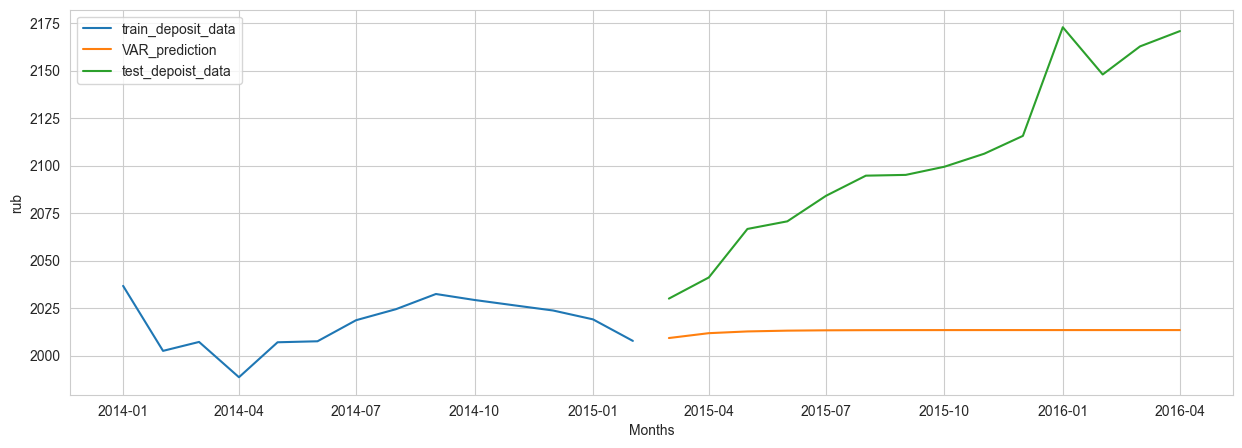

Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
  Test:  index=[28 29 30 31 32 33 34 35 36 37 38 39 40 41]
2016-05-01    2180.613223
2016-06-01    2187.849768
2016-07-01    2195.312565
2016-08-01    2202.541125
2016-09-01    2209.630009
2016-10-01    2216.577668
2016-11-01    2223.396641
2016-12-01    2230.095302
2017-01-01    2236.681230
2017-02-01    2243.160868
2017-03-01    2249.539785
2017-04-01    2255.822801
2017-05-01    2262.014102
2017-06-01    2268.117342
Freq: MS, dtype: float64


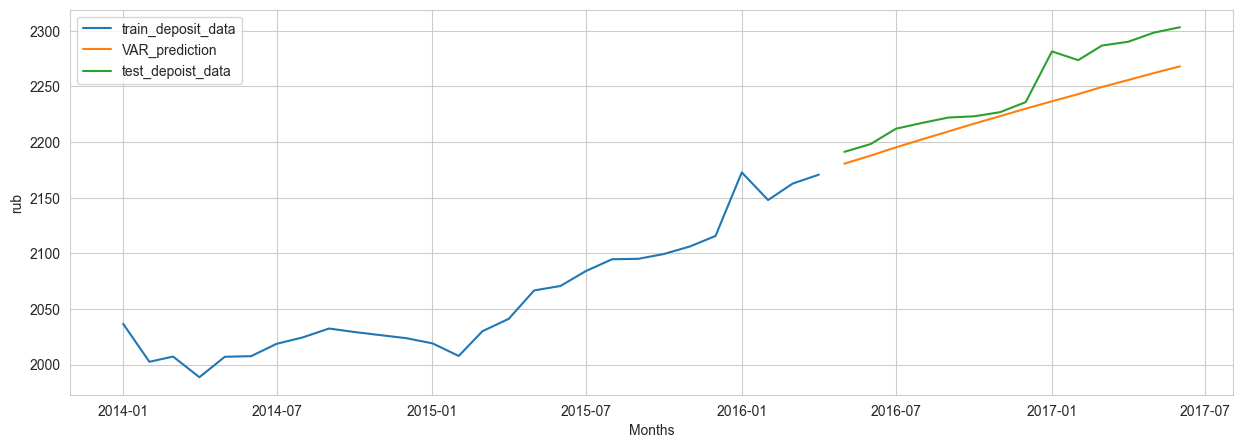

Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
  Test:  index=[42 43 44 45 46 47 48 49 50 51 52 53 54 55]
2017-07-01    2320.016193
2017-08-01    2328.524047
2017-09-01    2338.472079
2017-10-01    2348.176160
2017-11-01    2357.939692
2017-12-01    2367.716313
2018-01-01    2377.519844
2018-02-01    2387.352619
2018-03-01    2397.218218
2018-04-01    2407.119360
2018-05-01    2417.058387
2018-06-01    2427.037270
2018-07-01    2437.057683
2018-08-01    2447.121052
Freq: MS, dtype: float64


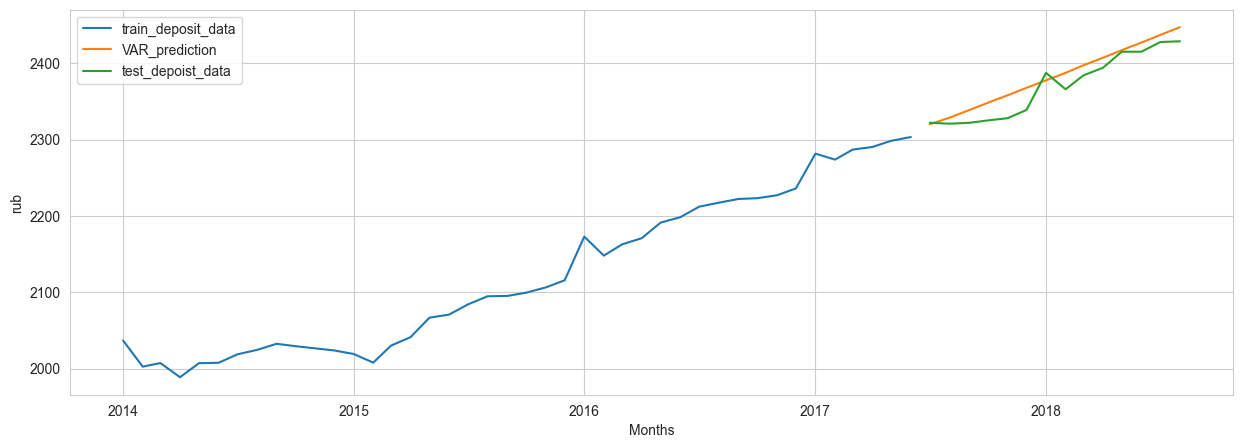

Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
  Test:  index=[56 57 58 59 60 61 62 63 64 65 66 67 68 69]
2018-09-01    2432.310264
2018-10-01    2440.660783
2018-11-01    2448.409608
2018-12-01    2456.269171
2019-01-01    2464.136764
2019-02-01    2472.020543
2019-03-01    2479.914657
2019-04-01    2487.815918
2019-05-01    2495.721427
2019-06-01    2503.628789
2019-07-01    2511.535996
2019-08-01    2519.441368
2019-09-01    2527.343502
2019-10-01    2535.241224
Freq: MS, dtype: float64


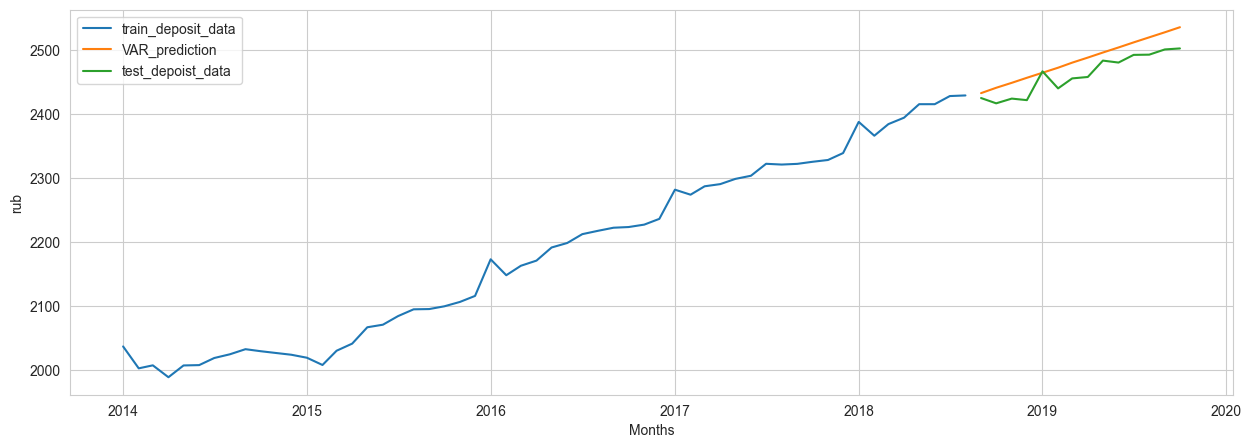

Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
  Test:  index=[70 71 72 73 74 75 76 77 78 79 80 81 82 83]
2019-11-01    2510.433506
2019-12-01    2517.069012
2020-01-01    2523.787178
2020-02-01    2530.434279
2020-03-01    2537.029813
2020-04-01    2543.576719
2020-05-01    2550.078652
2020-06-01    2556.538558
2020-07-01    2562.958910
2020-08-01    2569.341781
2020-09-01    2575.688911
2020-10-01    2582.001762
2020-11-01    2588.281572
2020-12-01    2594.529383
Freq: MS, dtype: float64


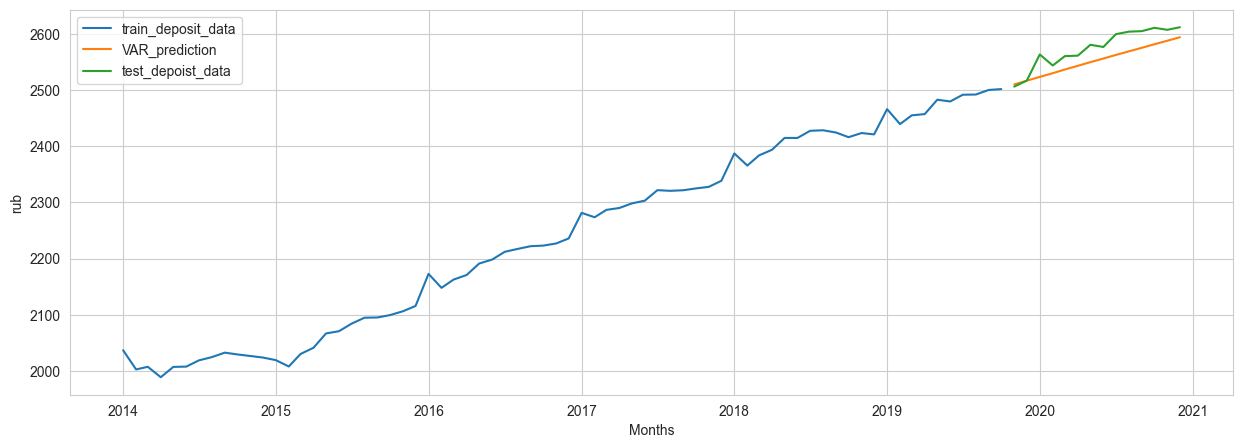

,Model,Fold,R2_score,RMSE,MAPE
0,ARIMA,0,-6.888955,123.858804,0.053315
1,ARIMA,1,-3.494374,81.053468,0.031751
2,ARIMA,2,0.665481,23.820096,0.008212
3,ARIMA,3,0.155714,27.836141,0.010886
4,ARIMA,4,0.461137,24.597132,0.00876
5,SARIMA,0,-4.253824,101.077594,0.043051
6,SARIMA,1,-1.149072,56.048309,0.021295
7,SARIMA,2,0.335347,33.576141,0.011399
8,SARIMA,3,0.637123,18.249207,0.007131
9,SARIMA,4,0.639111,20.129456,0.007291


In [71]:
# Обучение VAR с лагом 1

for i, (train_index, test_index) in enumerate(tscv.split(X2)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    # делим данные 
    train_data, test_data = X2.iloc[train_index,:],X2.iloc[test_index,:]

    best_rmse=np.float64('inf')
    
    # обучаем модели
    result_var = VAR(train_data)
    results_model = result_var.fit(1)
    predictions = results_model.forecast(train_data.values, len(test_index))[:,0]
    y_test = test_data['deposit_rub_box']
    y_pred = pd.Series(predictions, index = y_test.index)
    print(y_pred)

    # визуализация результата
    plt.figure(figsize=(15, 5))
    plt.plot(train_data['deposit_rub_box'], label="train_deposit_data")
    plt.plot(y_pred, label="VAR_prediction")
    plt.plot(y_test, label="test_depoist_data")
    
    plt.legend()
    plt.ylabel("rub")
    plt.xlabel("Months")
    plt.show()
    # фиксируем результаты
    results_df.loc[row_inx, 'Model'] = 'VAR_add_lag1'
    results_df.loc[row_inx, 'Fold'] = i
    results_df.loc[row_inx, 'R2_score'] = r2_score(y_test, y_pred)
    results_df.loc[row_inx, 'RMSE'] = root_mean_squared_error(y_test,y_pred)
    results_df.loc[row_inx, 'MAPE'] = mean_absolute_percentage_error(y_test, y_pred)
    
    row_inx += 1

results_df

In [72]:
# results_df.sort_values('R2_score', ascending=False)
results_df.sort_values('MAPE', ascending=True)
# results_df.sort_values('RMSE', ascending=True)

,Model,Fold,R2_score,RMSE,MAPE
11,VAR,1,0.851382,14.739141,0.005533
14,VAR,4,0.722329,17.656727,0.005591
17,VAR_add_lag1,2,0.827201,17.119985,0.006294
8,SARIMA,3,0.637123,18.249207,0.007131
9,SARIMA,4,0.639111,20.129456,0.007291
2,ARIMA,2,0.665481,23.820096,0.008212
4,ARIMA,4,0.461137,24.597132,0.00876
19,VAR_add_lag1,4,0.419961,25.519579,0.008826
18,VAR_add_lag1,3,0.323795,24.911716,0.009393
16,VAR_add_lag1,1,0.558382,25.407405,0.009434


Результаты в некоторых foldах улучшились по сравнению с предыдущими оценками, что доказывает, что ставку ЦБ (ставка займов коммерчиским банкам) можно успешно использовать для прогнозирования стоимости депозитов.